<strong><div style="text-align: center; font-size: 28px;">
Анализ ДТП.
</div><strong>

**Описание данных.**<br>
Заказчиком выступает проект «Карта ДТП» https://dtp-stat.ru/ — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. Это платформа сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.<br>	
Данные в формате geojson с сайта https://dtp-stat.ru/opendata

**Цель проекта.**<br>
Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Задачи:**<br>
1.	Провести исследовательский анализ данных о ДТП.<br>
2.	Сформулировать и проверить не менее трёх гипотез, основываясь на имеющихся признаках.

**Сформулируем предположения:**
1. Всему виной пьяные водители, надо усилить наказание.
2. Безопасность на дорогах растет для каждого из участников.
3. В личном автомобиле ехать безопаснее чем в автобусе.
4. Если пешеходы не будут нарушать, то не будут гибнуть.
5. Низкая скорость не влияет на тяжесть ДТП.

In [1]:
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.scale = 1.2

In [2]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pg
import warnings
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster
import json
import requests
from requests.exceptions import RequestException
import urllib.request
import codecs
from tqdm import tqdm
import os
import re
import geopandas as gpd
from pandas_geojson import read_geojson
import urllib
import dill as pickle
from scipy.stats import spearmanr
import math as mth
from scipy import stats as st
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

**Загрузка данных.**

Загрузим страницу по ссылке и запишем данные.

In [3]:

base_url = "https://dtp-stat.ru/opendata"

hd = {
        "User-Agent": "Mozilla/5.0 (compatible; U; ABrowse 0.6; Syllable) AppleWebKit/420+ (KHTML, like Gecko)"
      }


response = requests.get(base_url,headers=hd)


# Запись данных.
with open("dtp.html", "wb") as file:
    file.write(response.content)

Получим список ссылок, для загрузки файлов и загрузим файл.

In [4]:
list_for_download = re.findall(r'https:\/\/cms.dtp-stat.ru[\S][^\"\n]+',response.text)

In [5]:
def write_url_to_file(url):

    response = requests.get(url)

    path = f'dtp/' + re.search(r"[\w-]+.geojson", url)[0].replace('-', '_')

    file = open(path, "wb")
    file.write(response.content)
    file.close()
    return

Создадим папку для сохранения файлов с сайта и запустим функцию.

In [6]:
if os.path.isdir("dtp") == False:
    os.mkdir("dtp")

for url in list_for_download:    
    write_url_to_file(url)

In [7]:
def read_geojson(filename):
    with open(f"{filename}", encoding = "utf-8") as response:
        geo_json = json.load(response)
    return geo_json

Прочитаем файлы в дирректории dtp и переведем первый файл в датафрейм, посчитаем общее число скачанных файлов.

In [8]:
list_file = os.listdir("dtp")

print(f"Общее число файлов в директории dtp {len(list_file)}.")

Общее число файлов в директории dtp 85.


Функция по нормализации данных.

In [9]:
def normalize_json_to_data(data, col):

    data_out = pd.json_normalize(data.explode(col)[col])

    data_out = pd.concat(
        [pd.DataFrame(data.explode(col)["id"].values, columns = ["id"]), data_out],
        axis = 1)
    
    return data_out

In [10]:
geo_json = read_geojson(os.path.join("dtp",list_file[0]))

In [11]:
df = pd.json_normalize(geo_json["features"])

Удалим корневые названия и столбцы содержащие type.

In [12]:
df = df.drop([col for col in df.columns if "type" in col], axis =1)

df.columns = [col.split(".")[-1] for col in df.columns]

Создадим таблицы для машин, для пассажиров машин и для пешеходов. Дополнительно удалим все пустые строки, так как там нет пешеходов.

In [13]:
vehicles = normalize_json_to_data(df, "vehicles").reset_index(drop = True)

passengers = normalize_json_to_data(
    vehicles, "participants").reset_index(drop = True)

pedestrians = normalize_json_to_data(
    df, "participants").dropna().reset_index(drop = True)

Объединим таблицы pedestrians и passengers.

In [14]:
passengers_part = pd.concat([passengers,
                          pedestrians]).copy().reset_index(drop = True)

Функция, которая вернет обработанную таблицу.

In [15]:
def return_true_dfs(path):
    geo_json = read_geojson(os.path.join("dtp", path))

    df = pd.json_normalize(geo_json["features"])

    # Обрабатываем название колонок

    df = df.drop([col for col in df.columns if "type" in col], axis = 1)
    df.columns = [col.split(".")[-1] for col in df.columns]

    df["id"] = df["id"].astype("int32")

    # Таблица для машин.

    vehicles = normalize_json_to_data(df, "vehicles").reset_index(drop=True)

    # Таблица для пассажиров машин.

    passengers = normalize_json_to_data(
        vehicles, "participants").reset_index(drop=True)

    # Таблица для пешеходов.

    # Дополнительно удалим все пустые строки, так как там нет пешеходов.

    pedestrians = normalize_json_to_data(df,
                                       "participants").reset_index(drop=True)

    # Удяляем участников в транспортном средстве.

    vehicles = vehicles.drop(["participants"], axis = 1)
    df = df.drop(["participants", "vehicles"], axis = 1)

    #  Объединим таблицы pedestrians и passengers удалим пустые роли.

    passengers_part = pd.concat(
        [passengers,
         pedestrians]).copy().dropna(subset='role').reset_index(drop=True)

    # Возвращаем полученные датасеты.

    return df, vehicles, passengers_part

In [16]:
data_base, data_vehicles, passengers_part = return_true_dfs(list_file[0])

Обернём функцию, в функцию с условиями.

In [17]:
# _ означает, что данная переменная нам не нужна
# n = 1 устанавливает по умолчание значение = 1
def return_df(path, n = 1):
    
    if n == 1:
        df, _, _ = return_true_dfs(path)
        
    if n == 2:
        _, df, _ = return_true_dfs(path)
        
    if n == 3:
        _, _, df = return_true_dfs(path)

    return df

In [18]:
return_df(list_file[0]).head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


Прочитаем загруженные файлы и соберём основную таблицу.

In [19]:
data_base = pd.DataFrame()

for path in list_file:
    data_base = pd.concat([data_base, return_df(path)]).reset_index(drop = True)

In [20]:
data_base["parent_region"].unique()

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Чеченская Республика', 'Челябинская область',
       'Чукотский автономный округ', 'Чувашская Республика - Чувашия',
       'Еврейская автономная область', 'Ямало-Ненецкий автономный округ',
       'Ярославская область', 'Иркутская область', 'Ивановская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область - Кузбасс',
       'Хабаровский край', 'Ханты-Мансийский автономный округ - Югра',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курганская область', 'Курская область',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Московская область', 'Москва', 'Мурманская область',
       'Ненецкий автономный округ', 'Нижего

In [21]:
with open("data_base.pickle", "wb") as file:
    pickle.dump(data_base, file)

In [22]:
data_vehicles = pd.DataFrame()

for path in list_file:
    data_vehicles = pd.concat([data_vehicles,return_df(path, 2)])

In [23]:
data_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253995 entries, 0 to 15824
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int32  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
dtypes: float64(1), int32(1), object(4)
memory usage: 111.8+ MB


In [24]:
with open("data_vehicles.pickle", "wb") as file:
    pickle.dump(data_vehicles, file)

In [25]:
passengers_part = pd.DataFrame()

for path in list_file:
    passengers_part = pd.concat([passengers_part, return_df(path, 3)])

In [26]:
passengers_part.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3499172 entries, 0 to 28534
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 173.5+ MB


In [27]:
with open("passengers_part.pickle", "wb") as file:
    pickle.dump(passengers_part, file)

In [28]:
data_base.head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [29]:
data_vehicles.head()

,id,year,brand,color,model,category
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы


In [30]:
passengers_part.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [31]:
with open("data_base.pickle", "rb") as file:
    data = pickle.load(file)

In [32]:
data.head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419979 entries, 0 to 1419978
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   coordinates             1419979 non-null  object 
 1   id                      1419979 non-null  int32  
 2   tags                    1419979 non-null  object 
 3   light                   1419979 non-null  object 
 4   lat                     1409235 non-null  float64
 5   long                    1409235 non-null  float64
 6   nearby                  1419979 non-null  object 
 7   region                  1419979 non-null  object 
 8   scheme                  1338077 non-null  object 
 9   address                 1352718 non-null  object 
 10  weather                 1419979 non-null  object 
 11  category                1419979 non-null  object 
 12  datetime                1419979 non-null  object 
 13  severity                1419979 non-null  object 
 14  de

In [34]:
with open("data_vehicles.pickle", "rb") as file:
    vehicles = pickle.load(file)

In [35]:
vehicles.head()

,id,year,brand,color,model,category
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы


In [36]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253995 entries, 0 to 15824
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int32  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
dtypes: float64(1), int32(1), object(4)
memory usage: 111.8+ MB


In [37]:
with open("passengers_part.pickle", "rb") as file:
    participants = pickle.load(file)

In [38]:
participants.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [39]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3499172 entries, 0 to 28534
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 173.5+ MB


В итоге у нас получилось три таблицы: общая - где собраны все данные по всем регионам, таблица с транспортными средствами и таблица с участниками дорожного движения.

**1. Пьяные водители.**

Сформулируем гипотезы:<br>
**Нулевая:**<br>
В ДТП с участием пьяных водителей, людей гибнет не больше, чем с участием трезвых.<br>
**Альтернативная:**<br>
В ДТП с участием пьяных водителей, людей гибнет больше, чем с участием трезвых.

In [40]:
participants["role"].value_counts()

role
Водитель                                                                                                                            2192230
Пассажир                                                                                                                             816097
Пешеход                                                                                                                              435479
Велосипедист                                                                                                                          47981
Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира       7385
Name: count, dtype: int64

Отберём водителей.

In [41]:
drivers = participants[participants["role"] == "Водитель"].reset_index(drop = True)

In [42]:
drivers.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2576909,Водитель,Женский,[Несоблюдение очередности проезда],Не пострадал,5.0
4,2576909,Водитель,Мужской,[],Не пострадал,7.0


Пьяных обозначим "0", а трезвых "1".

In [43]:
def drunk_sober_drivers(row):
    row_list = row["violations"]
    if len(row_list) != 0:
        for violation in row_list:
            if "пьян" in violation:
                return 0
    return 1

In [44]:
drivers["drunk_sober"] = drivers.apply(drunk_sober_drivers, axis = 1)

In [45]:
drivers.head()

,id,role,gender,violations,health_status,years_of_driving_experience,drunk_sober
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN,1
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0,1
2,2321011,Водитель,Мужской,[],Не пострадал,25.0,1
3,2576909,Водитель,Женский,[Несоблюдение очередности проезда],Не пострадал,5.0,1
4,2576909,Водитель,Мужской,[],Не пострадал,7.0,1


In [46]:
drivers = drivers[["id", "drunk_sober"]]

Удалим дубликаты.

In [47]:
drivers = drivers.drop_duplicates().reset_index(drop = True)

In [48]:
drivers["drunk_sober"].value_counts()

drunk_sober
1    1307838
0     173707
Name: count, dtype: int64

Поскольку есть ДТП в которых участвовали и пьяные, и трезвые водители, то присвоим статус ДТП с участием пьяных водителей. 

In [49]:
drivers.loc[drivers["id"].duplicated(), "drunk_sober"] = 0

In [50]:
drivers = drivers.drop_duplicates(subset = "id").reset_index(drop = True)

In [51]:
drivers["drunk_sober"].value_counts()

drunk_sober
1    1262828
0     144567
Name: count, dtype: int64

Из основной таблицы присоединим информацию о погибших.

In [52]:
data1 = data[["id","dead_count"]]

In [53]:
data1.head()

,id,dead_count
0,2869171,0
1,2320091,0
2,2321011,0
3,2576909,0
4,2575209,0


In [54]:
drivers = drivers.merge(data1, on = "id", how = "left")

In [55]:
drivers.head()

,id,drunk_sober,dead_count
0,2869171,1,0
1,2320091,1,0
2,2321011,1,0
3,2576909,1,0
4,2575209,1,0


In [56]:
drivers.groupby("drunk_sober")["dead_count"].agg(["count", "max", "mean", "sum"])

,count,max,mean,sum
drunk_sober,,,,
0,144567,8,0.228406,33020
1,1262828,20,0.099699,125903


In [57]:
drivers_g = drivers.groupby("drunk_sober")["dead_count"].agg(["count", "max", "mean", "sum"]).reset_index()

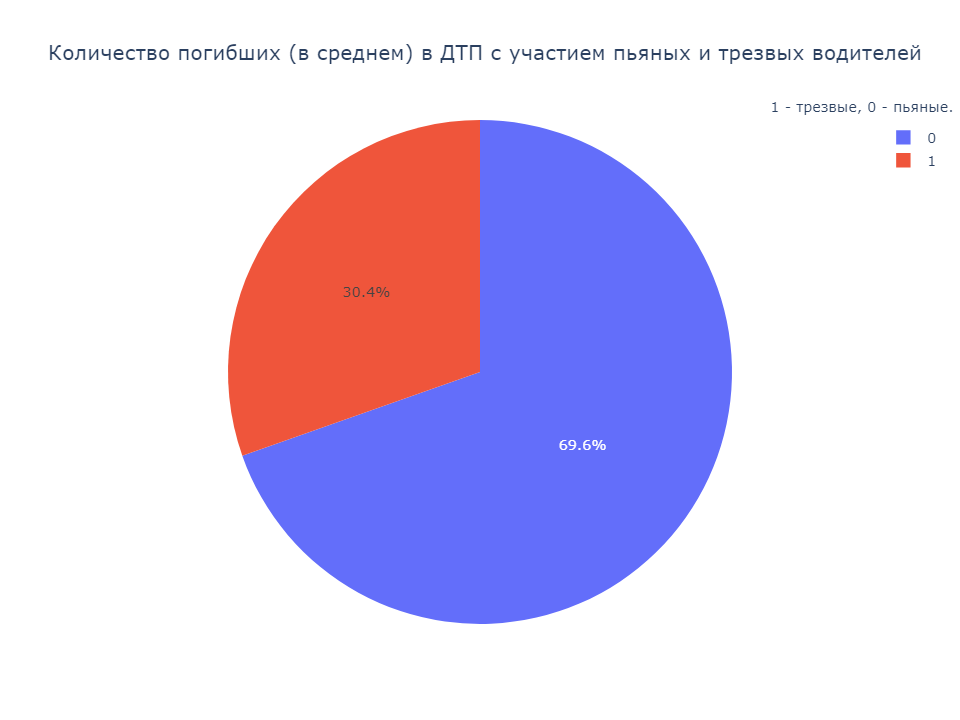

In [58]:
fig = pg.Figure(data = [pg.Pie(labels = drivers_g["drunk_sober"],
                             values = drivers_g["mean"])]) 
fig.update_layout(title = "Количество погибших (в среднем) в ДТП с участием пьяных и трезвых водителей",
                  width = 800,
                  height = 600,
                  annotations = [dict(x = 1.12,
                                    y = 1.05,
                                    text = "1 - трезвые, 0 - пьяные.",
                                    showarrow = False)])

fig.show()

Как видно среднее количество погибших в ДТП с участием пьяных водителей выше.

Однако, это среднее значение. Проверим количественное соотношение.

In [59]:
drivers.describe().round(1)

,id,drunk_sober,dead_count
count,1407395.0,1407395.0,1407395.0
mean,2240289.5,0.9,0.1
std,411854.4,0.3,0.4
min,1527476.0,0.0,0.0
25%,1883006.5,1.0,0.0
50%,2240394.0,1.0,0.0
75%,2596253.5,1.0,0.0
max,2957739.0,1.0,20.0


Максимальное число погибших составляет 20 человек.

Посчитаем корреляцию.

In [60]:
drivers["drunk_sober"].corr(drivers["dead_count"])

-0.10048310515625454

In [61]:
drivers[["drunk_sober", "dead_count"]].corr(method = "spearman")

,drunk_sober,dead_count
drunk_sober,1.000000,-0.111636
dead_count,-0.111636,1.000000


In [62]:
spearmanr(drivers[["drunk_sober", "dead_count"]])

SignificanceResult(statistic=-0.11163571049156058, pvalue=0.0)

Связь выражена слабо. Это позволяет предположить наличие других факторов.

Создадим таблицы с трезвыми и пьяными.

In [63]:
drunks = drivers[drivers["drunk_sober"] == 0]
sobers = drivers[drivers["drunk_sober"] == 1]

In [64]:
drunks.head()

,id,drunk_sober,dead_count
16,2758611,0,0
37,2666384,0,0
58,2313058,0,0
59,2315663,0,0
71,2783047,0,0


In [65]:
sobers.head()

,id,drunk_sober,dead_count
0,2869171,1,0
1,2320091,1,0
2,2321011,1,0
3,2576909,1,0
4,2575209,1,0


In [66]:
dead_drunks = len(drunks[drunks["dead_count"] != 0]["dead_count"])
alive_drunks = len(drunks[drunks["dead_count"] == 0]["dead_count"])
dead_sobers = len(sobers[sobers["dead_count"] != 0]["dead_count"])
alive_sobers = len(sobers[sobers["dead_count"] == 0]["dead_count"])

Посмотрим долю ДТП с погибшими.

In [67]:
print(f"Пьяные\n\
    Всего ДТП: - {len(drunks)}\n\
    ДТП с погибшими: - {dead_drunks}\n\
    ДТП без погибших:  - {alive_drunks}\n\
    Процент ДТП с погибшими: {dead_drunks/len(drunks):.2%}")

Пьяные
    Всего ДТП: - 144567
    ДТП с погибшими: - 27874
    ДТП без погибших:  - 116693
    Процент ДТП с погибшими: 19.28%


In [68]:
print(f"Трезвые\n\
    Всего ДТП: - {len(sobers)}\n\
    ДТП с погибшими: - {dead_sobers}\n\
    ДТП без погибших:  - {alive_sobers}\n\
    Процент ДТП с погибшими: {dead_sobers/len(sobers):.2%}")

Трезвые
    Всего ДТП: - 1262828
    ДТП с погибшими: - 107029
    ДТП без погибших:  - 1155799
    Процент ДТП с погибшими: 8.48%


In [69]:
drunks1 = drunks[drunks["dead_count"] != 0].groupby("drunk_sober")["dead_count"].agg(["count"]).reset_index()
sobers1 = sobers[sobers["dead_count"] != 0].groupby("drunk_sober")["dead_count"].agg(["count"]).reset_index()

In [70]:
drunks1["percent"] = round(dead_drunks/len(drunks) * 100, 2)
sobers1["percent"] = round(dead_sobers/len(sobers) * 100, 2)

In [71]:
drunks1

,drunk_sober,count,percent
0,0,27874,19.28


In [72]:
sobers1

,drunk_sober,count,percent
0,1,107029,8.48


In [73]:
def type(ds):
    
    if ds == 1:
        return "Трезвый"
        
    if ds == 0:
        return "Пьяный"

In [74]:
drivers_p = drivers
drivers_p["category"] = drivers_p["drunk_sober"].apply(type)

In [75]:
drivers_p.head()

,id,drunk_sober,dead_count,category
0,2869171,1,0,Трезвый
1,2320091,1,0,Трезвый
2,2321011,1,0,Трезвый
3,2576909,1,0,Трезвый
4,2575209,1,0,Трезвый


In [76]:
drivers_p1 = drivers_p[drivers_p["dead_count"] != 0].groupby("category")["dead_count"].agg(["count"]).reset_index()
drivers_p1

,category,count
0,Пьяный,27874
1,Трезвый,107029


In [77]:
drivers_a = pd.concat([drunks1, sobers1], ignore_index = True)

In [78]:
drivers_p1["percent"] = drivers_a["percent"]

In [79]:
drivers_p1

,category,count,percent
0,Пьяный,27874,19.28
1,Трезвый,107029,8.48


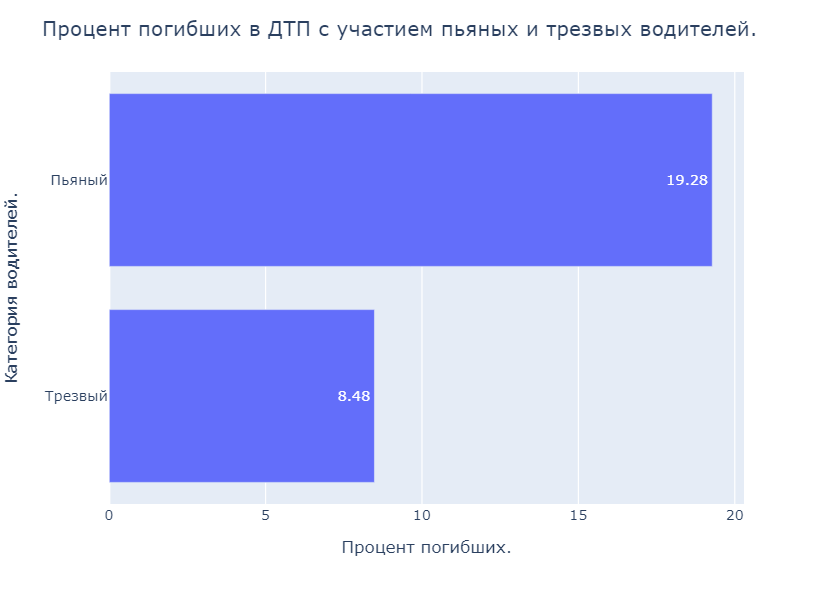

In [80]:
fig = px.bar(drivers_p1.sort_values(by = "percent"),
             x = "percent",
             y = "category",
             text = "percent"
            )
fig.update_layout( title = "Процент погибших в ДТП с участием пьяных и трезвых водителей.",
                   xaxis_title = "Процент погибших.",
                   yaxis_title = "Категория водителей.")
fig.show()

Как видно из графика, процент погибших в ДТП  участием пьяных водителей гораздо выше.

Посчитаем статистику.

In [81]:
alpha = 0.05 # критический уровень статистической значимости

victims = np.array([dead_drunks, dead_sobers])
all_part = np.array([len(drunks),len(sobers)])

In [82]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print("p-значение: ", p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: доля с погибшими в пьяном ДТП больше, есть значимая разница")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу, доля с погибшими в пьяном ДТП не больше"
        )

In [83]:
z_test(victims, all_part, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу: доля с погибшими в пьяном ДТП больше, есть значимая разница


По результатам проведённого теста видно, что доля с погибшими в пьяном ДТП больше. Для большй точности, сравним также и средние показатели и проведём t-test.

In [84]:
p_value = st.ttest_ind(drunks["dead_count"],
                       sobers["dead_count"],
                       equal_var = False,
                       alternative = "greater")[1]

print("p-значение: ", p_value)
if p_value > alpha:
    print("Не удалось отвергнуть нулевую гипотезу")
else:
    print("Нулевая гипотеза отвергнута")

p-значение:  0.0
Нулевая гипотеза отвергнута


Посмотрим на этот показатель в динамике.

In [85]:
data["datetime"].min()

'2015-01-01 00:01:00'

In [86]:
data["datetime"].max()

'2024-03-31 23:46:00'

In [87]:
victims = data[["id", "datetime", "dead_count"]]
victims["datetime"] = pd.to_datetime(victims["datetime"])
victims["month"] = victims["datetime"].dt.to_period("M")
victims = victims.sort_values(by = ["month"])

In [88]:
victims.head()

,id,datetime,dead_count,month
1412216,2379986,2015-01-17 14:00:00,0,2015-01
1391135,1589381,2015-01-30 18:30:00,0,2015-01
1391133,1589373,2015-01-31 13:30:00,0,2015-01
1391132,1589372,2015-01-31 03:00:00,0,2015-01
1391131,1589367,2015-01-31 20:50:00,0,2015-01


In [89]:
victims_all = drivers.merge(victims, on = "id", how = "left")

In [90]:
victims_all = victims_all.rename(columns = {"dead_count_x": "dead_count"})
victims_all = victims_all[["id", "dead_count", "category", "month"]]
victims_all = victims_all.drop_duplicates().reset_index(drop = True)
victims_all.head()

,id,dead_count,category,month
0,2869171,0,Трезвый,2023-05
1,2320091,0,Трезвый,2015-09
2,2321011,0,Трезвый,2017-08
3,2576909,0,Трезвый,2021-05
4,2575209,0,Трезвый,2021-05


In [91]:
victims_d = victims_all[(victims_all["category"] == "Пьяный") & (victims_all["dead_count"] != 0)]
victims_d = victims_d.sort_values(by = ["month"])

In [92]:
victims_d.head()

,id,dead_count,category,month
107214,2249205,1,Пьяный,2015-01
715649,2094426,1,Пьяный,2015-01
857428,1826673,1,Пьяный,2015-01
1024102,2435092,2,Пьяный,2015-01
1204480,1776891,1,Пьяный,2015-01


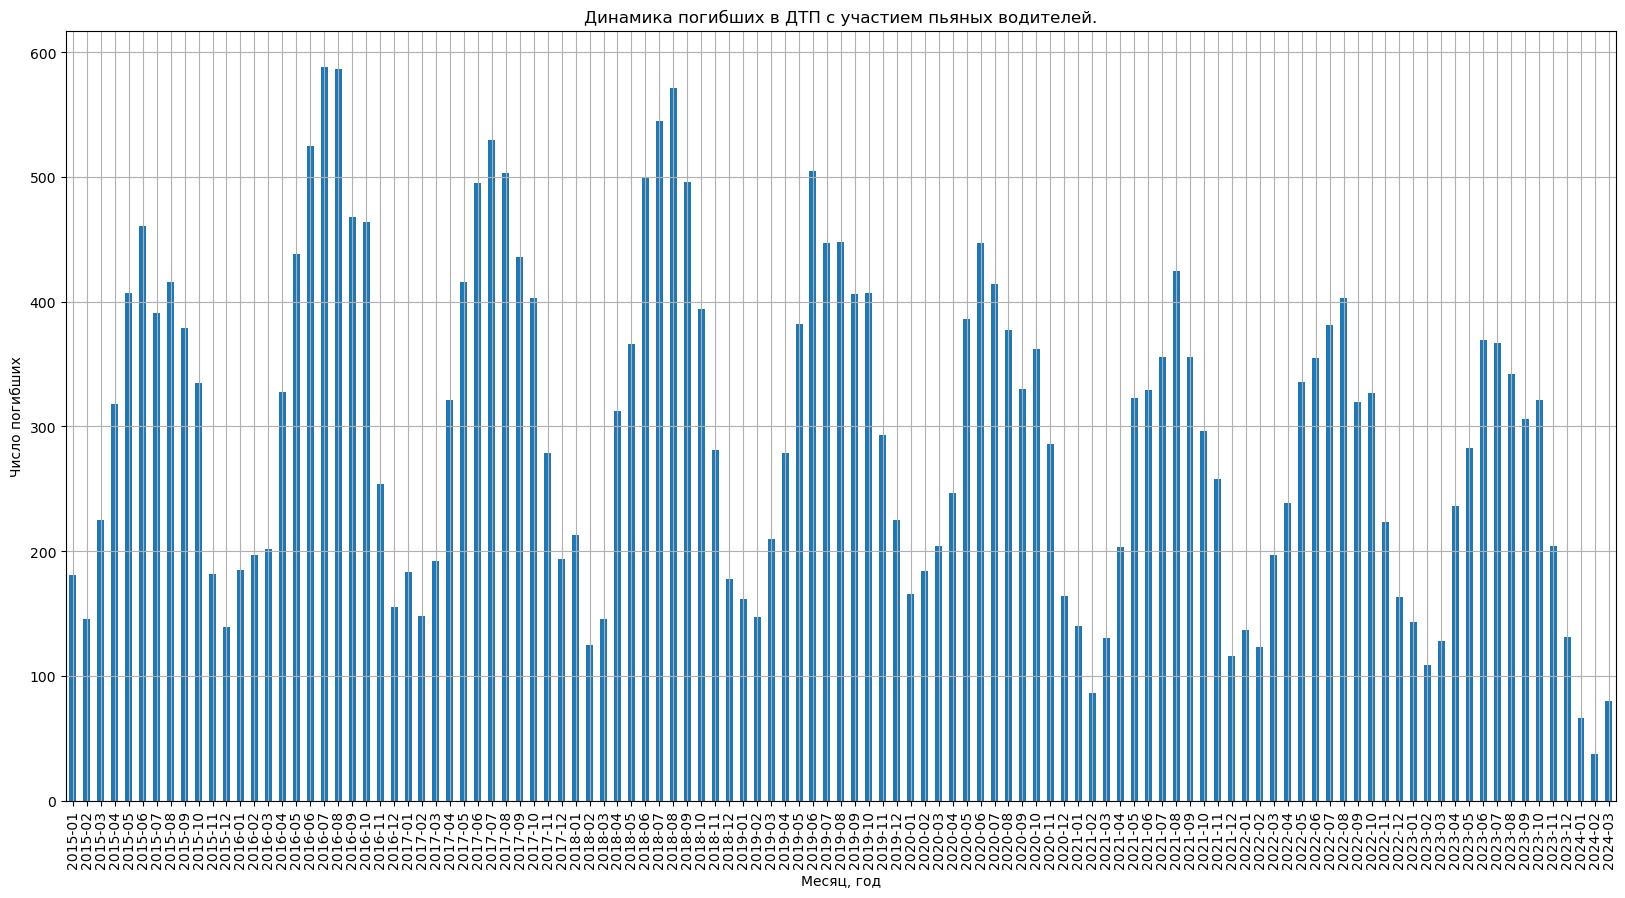

In [93]:
victims_d.groupby("month")["dead_count"].sum().plot(kind = "bar",
                                                       grid = True,
                                                       figsize = [20, 10]
                                                      )

plt.title("Динамика погибших в ДТП с участием пьяных водителей.")
plt.xlabel("Месяц, год")
plt.ylabel("Число погибших");

На графике видна ярко выраженная сезонность, при этом наблюдается заметная тенденция к снижению количества погибших в ДТП с участием пьяных водителей.

**Вывод:**<br>
На основании проведённого исследования, можно сделать вывод, что ДТП с участием пьяных водителей приводит к гораздо более серьёзным последствиям, процент погибших в них выше. Следовательно, необходимо обратить особое внимание на проблему управления автомобилем в нетрезвом виде. Однако, расчёт корреляции показал слабую связь между вождением автомобиля в нетрезвом состоянии и гибелью людей, что позволяет предположить наличие и других факторов, влияющих на этот показатель.<br>
Также нужно отметить, что в целом количество погибших в ДТП снижается с течением времени. Данный показатель может свидетельствовать как о том, что принимаемые государством меры приносят результат, так и о том, что, возможно, и сознательность самих участников дорожного движения растёт, что также может быть результатом прилагаемых усилий.

**2. Безопасность на дорогах.**

Чтобы выяснить растёт ли безопасность на дорогах и всех ли участников дорожного движения это касается, посмотрим как изменилось число пострадавших для всех категорий.

In [94]:
participants["role"].unique()

array(['Водитель', 'Пассажир', 'Велосипедист', 'Пешеход',
       'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'],
      dtype=object)

In [95]:
participants["role"].value_counts()

role
Водитель                                                                                                                            2192230
Пассажир                                                                                                                             816097
Пешеход                                                                                                                              435479
Велосипедист                                                                                                                          47981
Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира       7385
Name: count, dtype: int64

Последняя категория малоинформативна. Поскольку её размер составляет всего 0,2 % от общего количества, то, для удобства, не будем её использовать.

In [96]:
category = participants[participants["health_status"] != "Не пострадал"].reset_index(drop = True)

In [97]:
category =  category[["id", "role"]]

In [98]:
category.shape[0]

2029504

In [99]:
category = category.drop_duplicates().reset_index(drop = True)

In [100]:
category.shape[0]

1670773

In [101]:
category.head()

,id,role
0,2321011,Пассажир
1,2576909,Пассажир
2,2575209,Водитель
3,2547743,Водитель
4,2547743,Пассажир


In [102]:
category["role"].value_counts()

role
Водитель                                                                                                                            679365
Пассажир                                                                                                                            524902
Пешеход                                                                                                                             413018
Велосипедист                                                                                                                         47316
Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира      6172
Name: count, dtype: int64

In [103]:
category = category[~category["role"].str.contains("ДТП")]

In [104]:
category["role"].value_counts()

role
Водитель        679365
Пассажир        524902
Пешеход         413018
Велосипедист     47316
Name: count, dtype: int64

In [105]:
data2 = data[["id", "datetime", "dead_count", "injured_count"]]
data2["datetime"] = pd.to_datetime(data2["datetime"])
data2["year"] = data2["datetime"].dt.to_period("Y")

In [106]:
data2.head()

,id,datetime,dead_count,injured_count,year
0,2869171,2023-05-24 19:30:00,0,1,2023
1,2320091,2015-09-16 13:00:00,0,1,2015
2,2321011,2017-08-25 15:30:00,0,1,2017
3,2576909,2021-05-29 19:40:00,0,1,2021
4,2575209,2021-05-25 16:40:00,0,1,2021


In [107]:
category_all = category.merge(data2, on = "id", how = "left")

In [108]:
category_all = category_all[category_all["year"] < "2024"]

In [109]:
category_all.head()

,id,role,datetime,dead_count,injured_count,year
0,2321011,Пассажир,2017-08-25 15:30:00,0,1,2017
1,2576909,Пассажир,2021-05-29 19:40:00,0,1,2021
2,2575209,Водитель,2021-05-25 16:40:00,0,1,2021
3,2547743,Водитель,2021-02-22 13:50:00,0,3,2021
4,2547743,Пассажир,2021-02-22 13:50:00,0,3,2021


In [110]:
category_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1638203 entries, 0 to 1664600
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   id             1638203 non-null  int32         
 1   role           1638203 non-null  object        
 2   datetime       1638203 non-null  datetime64[ns]
 3   dead_count     1638203 non-null  int64         
 4   injured_count  1638203 non-null  int64         
 5   year           1638203 non-null  period[A-DEC] 
dtypes: datetime64[ns](1), int32(1), int64(2), object(1), period[A-DEC](1)
memory usage: 81.2+ MB


In [111]:
category_d = category_all.pivot_table(index = "year", columns = "role", values = "dead_count", aggfunc = "sum")
category_d

role,Велосипедист,Водитель,Пассажир,Пешеход
year,,,,
2015,424,14912,11001,7082
2016,400,13380,9961,5847
2017,390,12506,9043,5700
2018,373,11952,8622,5211
2019,370,11244,8098,4840
2020,371,10860,7382,4406
2021,314,10425,7150,3842
2022,318,9787,6589,3478
2023,305,10057,6846,3343


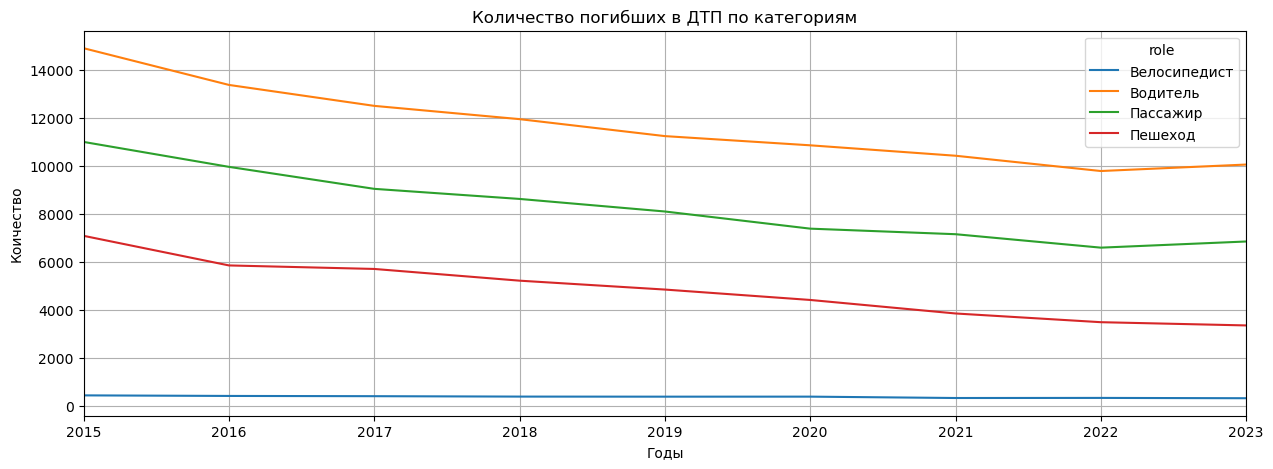

In [112]:
(
    category_all
    .pivot_table(index = "year", columns = "role", values = "dead_count", aggfunc = "sum")
    .plot(grid = True, figsize = (15, 5))
)

plt.title("Количество погибших в ДТП по категориям")
plt.ylabel("Коичество")
plt.xlabel("Годы")
plt.show()

In [113]:
category_i = category_all.pivot_table(index = "year", columns = "role", values = "injured_count", aggfunc = "sum")
category_i

role,Велосипедист,Водитель,Пассажир,Пешеход
year,,,,
2015,5219,129061,118323,54281
2016,5113,122875,115024,50217
2017,4853,121457,111930,50033
2018,5116,118962,112855,47416
2019,5150,117100,110842,46208
2020,5527,106459,94644,37293
2021,4689,98506,88101,35276
2022,4483,90507,81354,33102
2023,4988,95683,83163,33499


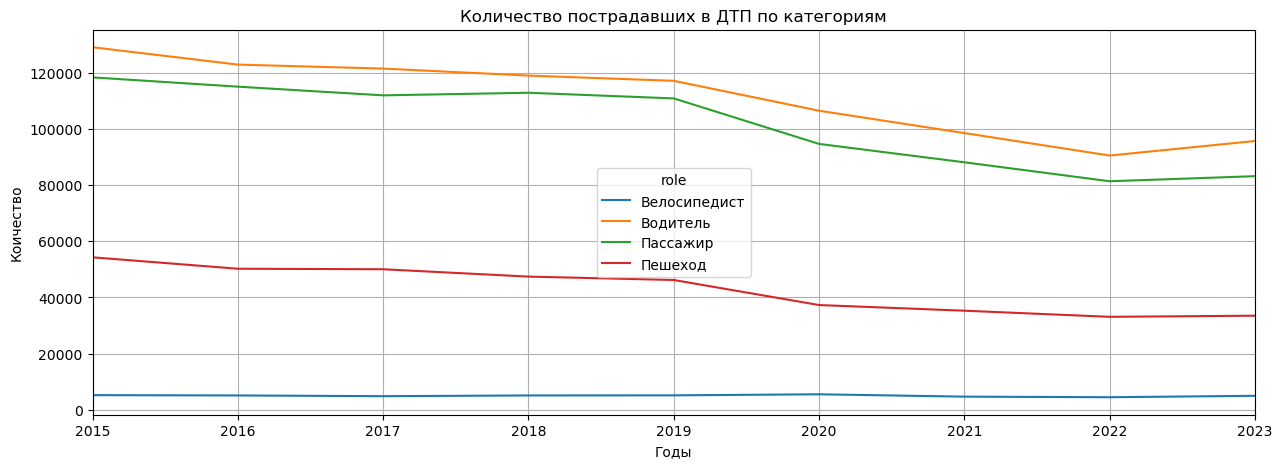

In [114]:
(
    category_all
    .pivot_table(index = "year", columns = "role", values = "injured_count", aggfunc = "sum")
    .plot(grid = True, figsize = (15, 5))
)
plt.title("Количество пострадавших в ДТП по категориям")
plt.ylabel("Коичество")
plt.xlabel("Годы")
plt.show()

**Вывод:**<br>
Как видно из полученных данных, количество погибших и пострадавших в ДТП имеет тенденцию к плавному снижению для всех участниов дорожного движения. Однако, нужно отметить, что оно замедлилось в 2023 году и даже наблюдается небольшой рост обоих показателей среди водителей и пассажиров, что, скорее всего, является "стабилизацией" после пидемии короновируса. Среди погибших больше всего водителей, что логично, на втором месте пассажиры. А вот пострадавших водителей и пассажиров почти поровну. Также обращают на себя внимание низкие и ровные показатели среди велосипедистов. Скорее всего, это обусловлено тем, что их в целом меньше и ездят они, как правило, по тротуарам или специально выделенным дорожкам.

**3. В личном автомобиле ехать безопаснее чем в автобусе.**

Предположим, что водители пассажиры легковых автомобилей (примем, что под "личным автомобилем" понимается легковой автомобиль) реже гибнут и получают травмы в ДТП, чем водители и пассажиры автобусов. Поскольку в задании указан именно автомобиль, не будем рассматривать мопеды и мотоциклы, тем более, что у них своя специфика.

Сформулируем гипотезы:<br>
**Нулевая:**<br>
Среди пострадавших в ДТП водителей и пассажиров автобусов не больше, чем водителей и пассажиров лекговых автомобилей.<br>
**Альтернативная:**<br>
Среди пострадавших в ДТП водителей и пассажиров автобусов больше, чем водителей и пассажиров легковых автомобилей.

Выделим две категории: автобусы и легковые автомобили.

In [115]:
data.head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [116]:
vehicles.head()

,id,year,brand,color,model,category
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы


In [117]:
participants.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [118]:
vehicles["category"].unique()

array(['Мопеды с двигателем внутреннего сгорания менее 50 см. куб.',
       'С-класс (малый средний, компактный) до 4,3 м',
       'Одноэтажные длиной от 8 до 12 м', 'В-класс (малый) до 3,9 м',
       'Мотоциклы', 'Одноэтажные длиной от 5 до 8 м',
       'D-класс (средний) до 4,6 м', 'Велосипеды',
       'Персональное электрическое средство передвижения малой мощности',
       'Экскаваторы', 'Бортовые грузовые автомобили', 'Цистерны',
       'Мопеды с электродвигателем менее 4 кВт',
       'Одноэтажные длиной не более 5 м',
       'Е-класс (высший средний, бизнес-класс) до 4,9 м', 'Фургоны',
       'Минивэны и универсалы повышенной вместимости', 'Седельные тягачи',
       'Трамваи', 'Прочая спецтехника', 'Прочие легковые автомобили',
       'А-класс (особо малый) до 3,5 м',
       'Оснащённые специализированным оборудованием автотранспортные средства аварийно-спасательных служб и полиции',
       'Автомобили скорой медицинской помощи', 'Самосвалы',
       'Автокраны и транспортные сред

In [119]:
participants["role"].unique()

array(['Водитель', 'Пассажир', 'Велосипедист', 'Пешеход',
       'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'],
      dtype=object)

In [120]:
participants_c = participants[["id", "role", "health_status"]]

In [121]:
participants_c.head()

,id,role,health_status
0,2869171,Водитель,Не пострадал
1,2320091,Водитель,Не пострадал
2,2321011,Водитель,Не пострадал
3,2321011,Пассажир,Не пострадал
4,2321011,Пассажир,"Раненый, находящийся (находившийся) на амбула..."


In [122]:
participants_c = participants_c[~participants_c["role"].str.contains("ДТП")]

In [123]:
participants_c["role"].value_counts()

role
Водитель        2192230
Пассажир         816097
Пешеход          435479
Велосипедист      47981
Name: count, dtype: int64

In [124]:
participants_c = participants_c.query('(role == "Водитель" or role == "Пассажир") and health_status != "Не пострадал"')

In [125]:
participants_c.head()

,id,role,health_status
4,2321011,Пассажир,"Раненый, находящийся (находившийся) на амбула..."
6,2576909,Пассажир,"Раненый, находящийся (находившийся) на стацион..."
8,2575209,Водитель,"Раненый, находящийся (находившийся) на амбулат..."
10,2547743,Водитель,"Раненый, находящийся (находившийся) на стацион..."
11,2547743,Пассажир,"Раненый, находящийся (находившийся) на амбулат..."


In [126]:
participants_c = participants_c[["id", "role"]]

In [127]:
participants_c.head()

,id,role
4,2321011,Пассажир
6,2576909,Пассажир
8,2575209,Водитель
10,2547743,Водитель
11,2547743,Пассажир


In [128]:
participants_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541248 entries, 4 to 26591
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1541248 non-null  int32 
 1   role    1541248 non-null  object
dtypes: int32(1), object(1)
memory usage: 29.4+ MB


Проверим дубликаты.

In [129]:
participants_c.duplicated().sum()

336981

In [130]:
participants_c.loc[participants_c.duplicated()]

,id,role
12,2547743,Пассажир
46,2315694,Пассажир
47,2315694,Пассажир
70,2771065,Пассажир
71,2771065,Пассажир
...,...,...
25489,2382142,Пассажир
25490,2382142,Пассажир
25504,2566039,Пассажир
25515,2376542,Пассажир


In [131]:
participants_c.loc[participants_c["id"] == 2547743]

,id,role
10,2547743,Водитель
11,2547743,Пассажир
12,2547743,Пассажир


In [132]:
data.loc[data["id"] == 2547743]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
5,"[83.708739, 53.290476]",2547743,[Дорожно-транспортные происшествия],Светлое время суток,53.290476,83.708739,"[Эстакада, путепровод]",Барнаул,210,"г Барнаул, Объездная дорога в обход г. Барнаул...",[Ясно],Столкновение,2021-02-22 13:50:00,Тяжёлый,0,3,Алтайский край,[Обработанное противогололедными материалами],4,[Все участники]


In [133]:
participants_c.loc[participants_c["id"] == 2600257]

,id,role
25842,2600257,Пассажир
25844,2600257,Пассажир


In [134]:
data.loc[data["id"] == 2600257]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
1410693,"[109.023106, 51.185604]",2600257,[Дорожно-транспортные происшествия],Светлое время суток,51.185604,109.023106,[Мост],Петровск-Забайкальский район,None,"Р-258 ""Байкал"" Иркутск - Улан-Удэ - Чита, 665 км",[Ясно],Столкновение,2021-07-25 19:20:00,Легкий,0,2,Забайкальский край,[Сухое],4,[Все участники]


В основной таблице участников больше. Скорее всего, это связано с тем, что в ДТП также участвовали и пешеходы. Вполне возможно, что именно из-за этого и появились дубликаты.

Сгруппируем данные, чтобы избавиться от них.

In [135]:
participants_c = participants_c.groupby(["id", "role"]).agg({"role" : "count"})
participants_c.rename(columns = {"role": "quantity"}, inplace = True )
participants_c.head()

,,quantity
id,role,
1527480,Пассажир,1
1527481,Пассажир,1
1527483,Водитель,1
1527484,Пассажир,1
1527485,Водитель,2


In [136]:
participants_c = participants_c.reset_index()
participants_c = participants_c[["id", "role"]]
participants_c.head()

,id,role
0,1527480,Пассажир
1,1527481,Пассажир
2,1527483,Водитель
3,1527484,Пассажир
4,1527485,Водитель


In [137]:
participants_c.shape[0]

1204267

In [138]:
participants_c.duplicated().sum()

0

Проверим дубликаты по столбцу "id".

In [139]:
participants_c.loc[participants_c["id"] == 2547743]

,id,role
858411,2547743,Водитель
858412,2547743,Пассажир


In [140]:
data.loc[data["id"] == 2547743]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
5,"[83.708739, 53.290476]",2547743,[Дорожно-транспортные происшествия],Светлое время суток,53.290476,83.708739,"[Эстакада, путепровод]",Барнаул,210,"г Барнаул, Объездная дорога в обход г. Барнаул...",[Ясно],Столкновение,2021-02-22 13:50:00,Тяжёлый,0,3,Алтайский край,[Обработанное противогололедными материалами],4,[Все участники]


In [141]:
participants_c.loc[participants_c["id"] == 2600257]

,id,role
903636,2600257,Пассажир


In [142]:
data.loc[data["id"] == 2600257]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
1410693,"[109.023106, 51.185604]",2600257,[Дорожно-транспортные происшествия],Светлое время суток,51.185604,109.023106,[Мост],Петровск-Забайкальский район,None,"Р-258 ""Байкал"" Иркутск - Улан-Удэ - Чита, 665 км",[Ясно],Столкновение,2021-07-25 19:20:00,Легкий,0,2,Забайкальский край,[Сухое],4,[Все участники]


In [143]:
participants_c["id"].duplicated().sum()

243993

In [144]:
participants_c.loc[participants_c["id"].duplicated()]

,id,role
7,1527493,Пассажир
9,1527496,Пассажир
27,1527529,Пассажир
31,1527535,Пассажир
40,1527554,Пассажир
...,...,...
1204237,2957698,Пассажир
1204239,2957699,Пассажир
1204243,2957702,Пассажир
1204252,2957719,Пассажир


Дубли в этом столбце появились потому, что в одном ДТП могут участвовать и водители, и пассажиры.

In [145]:
participants_c.shape[0]

1204267

In [146]:
participants_c["id"].duplicated().sum()

243993

Чтобы в дальнейшем избежать двойных значений при подсчёте удалим дубликаты в столбце "id".

In [147]:
participants_c = participants_c.drop_duplicates(subset = ["id"])

In [148]:
participants_c.duplicated().sum()

0

In [149]:
participants_c["id"].duplicated().sum()

0

In [150]:
participants_c = participants_c[["id"]]

In [151]:
participants_c.head()

,id
0,1527480
1,1527481
2,1527483
3,1527484
4,1527485


In [152]:
participants_c = participants_c.merge(data2, on = "id", how = "left")

In [153]:
participants_c = participants_c[["id", "dead_count", "injured_count"]]

In [154]:
participants_c.head()

,id,dead_count,injured_count
0,1527480,0,1
1,1527481,0,1
2,1527483,0,1
3,1527484,0,1
4,1527485,0,2


In [155]:
participants_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960274 entries, 0 to 960273
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   id             960274 non-null  int32
 1   dead_count     960274 non-null  int64
 2   injured_count  960274 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 18.3 MB


In [156]:
def category (row):
    
    if "легко" in row or "класс" in row or "спорт" in row:
        return "Легковой автомобиль"
    elif "обус" in row or "Одноэтаж" in row or "Двухэтаж" in row or "Двухярус" in row :
        return "Автобус"
    else:
        return "Другое"

In [157]:
vehicles_c = vehicles[["id", "category"]]

In [158]:
vehicles_c.head()

,id,category
0,2869171,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,Одноэтажные длиной от 8 до 12 м
3,2576909,"В-класс (малый) до 3,9 м"
4,2576909,Мотоциклы


В столбце "category" присутствуют пропуски. Поскольку эти строки не понадобятся и для более точной категоризации, удалим их.

In [159]:
vehicles_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253995 entries, 0 to 15824
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        int32 
 1   category  object
dtypes: int32(1), object(1)
memory usage: 43.0+ MB


In [160]:
vehicles_c.isna().sum()

id              0
category    13047
dtype: int64

In [161]:
vehicles_c = vehicles_c.dropna()

In [162]:
vehicles_c["class"] = vehicles_c["category"].apply(category)

In [163]:
vehicles_c.head()

,id,category,class
0,2869171,Мопеды с двигателем внутреннего сгорания менее...,Другое
1,2320091,"С-класс (малый средний, компактный) до 4,3 м",Легковой автомобиль
2,2321011,Одноэтажные длиной от 8 до 12 м,Автобус
3,2576909,"В-класс (малый) до 3,9 м",Легковой автомобиль
4,2576909,Мотоциклы,Другое


In [164]:
vehicles_c["class"].unique()

array(['Другое', 'Легковой автомобиль', 'Автобус'], dtype=object)

По причиние не всегда корректного и аккуратного заполнения столбца "category", в категорию "Автобусы" попали также и микроавтобусы.

In [165]:
vehicles_c["class"].value_counts()

class
Легковой автомобиль    1650469
Другое                  520964
Автобус                  69515
Name: count, dtype: int64

In [166]:
vehicles_c = vehicles_c[["id", "class"]]

In [167]:
vehicles_c = vehicles_c[vehicles_c["class"] != "Другое"]

In [168]:
vehicles_c.head()

,id,class
1,2320091,Легковой автомобиль
2,2321011,Автобус
3,2576909,Легковой автомобиль
5,2575209,Легковой автомобиль
6,2575209,Легковой автомобиль


In [169]:
vehicles_c.shape[0]

1719984

Проверим дубликаты.

In [170]:
vehicles_c.duplicated().sum()

478559

In [171]:
vehicles_c["id"].duplicated().sum()

502551

Как и в случае с водитеями и пассажирами, избавимся от них с помощью группировки.

In [172]:
vehicles_c = vehicles_c.groupby(["id", "class"]).agg({"class" : "count"})
vehicles_c.rename(columns = {"class": "quantity"}, inplace = True )
vehicles_c.head()

,,quantity
id,class,
1527476,Легковой автомобиль,1
1527477,Легковой автомобиль,1
1527478,Легковой автомобиль,1
1527479,Легковой автомобиль,1
1527480,Легковой автомобиль,1


In [173]:
vehicles_c = vehicles_c.reset_index()
vehicles_c = vehicles_c[["id", "class"]]
vehicles_c.head()

,id,class
0,1527476,Легковой автомобиль
1,1527477,Легковой автомобиль
2,1527478,Легковой автомобиль
3,1527479,Легковой автомобиль
4,1527480,Легковой автомобиль


In [174]:
vehicles_c.shape[0]

1241425

In [175]:
vehicles_c.duplicated().sum()

0

Также провеим дубликаты по столбцу "id".

In [176]:
vehicles_c["id"].duplicated().sum()

23992

In [177]:
vehicles_c.loc[vehicles_c["id"].duplicated()]

,id,class
178,1527687,Легковой автомобиль
378,1527926,Легковой автомобиль
408,1527956,Легковой автомобиль
410,1527957,Легковой автомобиль
426,1527976,Легковой автомобиль
...,...,...
1240434,2956616,Легковой автомобиль
1240623,2956824,Легковой автомобиль
1240643,2956843,Легковой автомобиль
1240795,2957017,Легковой автомобиль


In [178]:
vehicles_c.loc[vehicles_c["id"] == 1527687]

,id,class
177,1527687,Автобус
178,1527687,Легковой автомобиль


In [179]:
data.loc[data["id"] == 1527687]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
552840,"[37.632944, 55.662398]",1527687,[Дорожно-транспортные происшествия],Светлое время суток,55.662398,37.632944,"[Многоквартирные жилые дома, Выезд с прилегающ...",Нагатино-Садовники,070,"г Москва, ш Каширское, 21",[Ясно],Столкновение,2018-02-08 13:15:00,Легкий,0,1,Москва,"[Обработанное противогололедными материалами, ...",3,[Все участники]


In [180]:
participants_c.loc[participants_c["id"] == 1527687]

,id,dead_count,injured_count
117,1527687,0,1


In [181]:
vehicles_c.loc[vehicles_c["id"] == 2948994]

,id,class
1233901,2948994,Автобус
1233902,2948994,Легковой автомобиль


In [182]:
data.loc[data["id"] == 2948994]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
1024388,"[38.845983, 47.270013]",2948994,[Дорожно-транспортные происшествия],Светлое время суток,47.270013,38.845983,[],Неклиновский район,140,А-280 Ростов-на-Дону - Таганрог - граница с До...,[Ясно],Столкновение,2023-09-29 10:00:00,Легкий,0,2,Ростовская область,[Сухое],3,[Все участники]


In [183]:
participants_c.loc[participants_c["id"] == 2948994]

,id,dead_count,injured_count
954525,2948994,0,2


Здесь дубликаты обусловлены тем, что в одном ДТП могут участвовать как автобусы, так и легковые автомобили. Тем не менее, при объединении таблиц, из-за них могут возникнуть двойные значения при подсчёте пострадавших. Чтобы избежать искажения данных, и учитывая, что таких дубликатов менее 2%, удалим их.

In [184]:
vehicles_c = vehicles_c.drop_duplicates(subset = ["id"], keep = False)

In [185]:
vehicles_c.duplicated().sum()

0

In [186]:
vehicles_c["id"].duplicated().sum()

0

In [187]:
vehicles_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193441 entries, 0 to 1241424
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1193441 non-null  int32 
 1   class   1193441 non-null  object
dtypes: int32(1), object(1)
memory usage: 22.8+ MB


In [188]:
vehicles_all = participants_c.merge(vehicles_c, on = "id", how = "left")

In [189]:
vehicles_all = vehicles_all[["id", "class", "dead_count", "injured_count"]]

In [190]:
vehicles_all.head()

,id,class,dead_count,injured_count
0,1527480,Легковой автомобиль,0,1
1,1527481,Автобус,0,1
2,1527483,Легковой автомобиль,0,1
3,1527484,NaN,0,1
4,1527485,Легковой автомобиль,0,2


In [191]:
vehicles_all.shape[0]

960274

In [192]:
vehicles_all.duplicated().sum()

0

In [193]:
vehicles_all["id"].duplicated().sum()

0

In [194]:
vehicles_all.isna().sum()

id                    0
class            146341
dead_count            0
injured_count         0
dtype: int64

Эти пропуски нужно удалить, поскольку данные из строк с пропущенными значениями в столбце "class" нельзя будет использовать в дальнейшем исследовании.

In [195]:
vehicles_all = vehicles_all.dropna()

In [196]:
vehicles_all.isna().sum()

id               0
class            0
dead_count       0
injured_count    0
dtype: int64

In [197]:
vehicles_all.head()

,id,class,dead_count,injured_count
0,1527480,Легковой автомобиль,0,1
1,1527481,Автобус,0,1
2,1527483,Легковой автомобиль,0,1
4,1527485,Легковой автомобиль,0,2
5,1527487,Легковой автомобиль,0,1


In [198]:
vehicles_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813933 entries, 0 to 960273
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             813933 non-null  int32 
 1   class          813933 non-null  object
 2   dead_count     813933 non-null  int64 
 3   injured_count  813933 non-null  int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 27.9+ MB


In [199]:
vehicles_all.describe().round(2)

,id,dead_count,injured_count
count,813933.00,813933.00,813933.00
mean,2245135.15,0.12,1.45
std,413307.90,0.42,1.00
min,1527480.00,0.00,0.00
25%,1879371.00,0.00,1.00
50%,2245491.00,0.00,1.00
75%,2604817.00,0.00,2.00
max,2957738.00,19.00,44.00


Масимальное количество погибших - 19, пострадавших - 44.

**Коичество погибших.**

In [200]:
vehicles_d = vehicles_all.groupby("class")["dead_count"].agg(["count", "max", "mean", "sum"]).reset_index()
vehicles_d

,class,count,max,mean,sum
0,Автобус,32963,19,0.035980,1186
1,Легковой автомобиль,780970,16,0.120501,94108


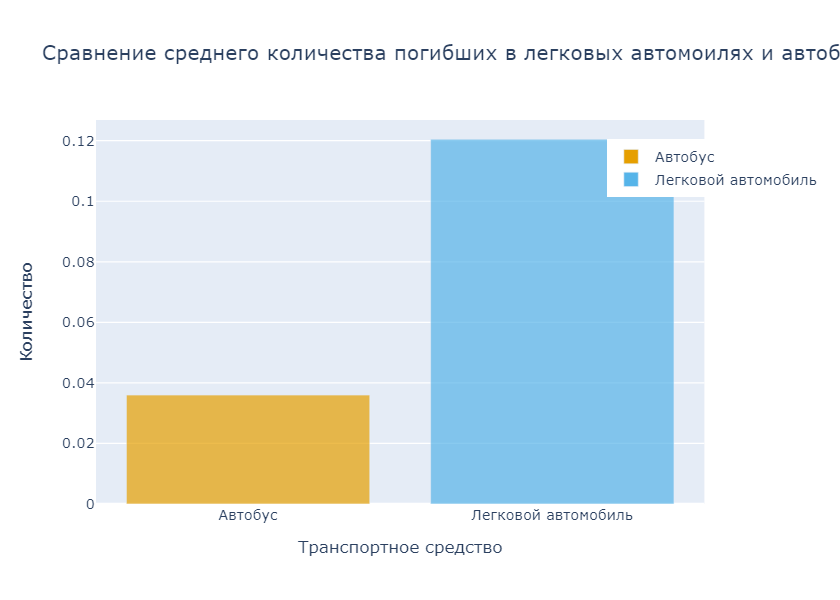

In [201]:
vehicles_d1 = vehicles_d[vehicles_d["class"] == "Автобус"]
vehicles_d2 = vehicles_d[vehicles_d["class"] == "Легковой автомобиль"]

fig = pg.Figure()
fig.add_trace(pg.Bar(x = vehicles_d1["class"], y = vehicles_d1["mean"],\
                     name = "Автобус", marker = {"color": "#E69F00", "opacity": 0.7}))
fig.add_trace(pg.Bar(x = vehicles_d2["class"], y = vehicles_d2["mean"],\
                     name = "Легковой автомобиль", marker = {"color": "#56B4E9", "opacity": 0.7}))
fig.update_layout(title = "Сравнение среднего количества погибших в легковых автомоилях и автобусах",\
                  xaxis_title = "Транспортное средство", yaxis_title = "Количество", legend = dict(y = 0.95, x = 0.84))
fig.update_traces(hoverinfo = "all", hovertemplate = "Количество: %{y}")

fig.show()

Как видно на этом графике, среднее количество погибших выше в легковом автомобиле.

Теперь посчитаем корреляцию.

Обозначим автобус "1", а легковой автомобиль "0".

In [202]:
def classification (row):
    
    if "Автобус" in row:
        return "1"
    elif "Легковой автомобиль" in row :
        return "0"

In [203]:
vehicles_s = vehicles_all

In [204]:
vehicles_s["classification"] = vehicles_s["class"].apply(classification)

In [205]:
vehicles_s = vehicles_s[["id", "classification", "dead_count"]]

In [206]:
vehicles_s.head()

,id,classification,dead_count
0,1527480,0,0
1,1527481,1,0
2,1527483,0,0
4,1527485,0,0
5,1527487,0,0


In [207]:
vehicles_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813933 entries, 0 to 960273
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813933 non-null  int32 
 1   classification  813933 non-null  object
 2   dead_count      813933 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 21.7+ MB


In [208]:
vehicles_s["classification"] = vehicles_s["classification"].astype("int32")
vehicles_s["dead_count"] = vehicles_s["dead_count"].astype("int32")

In [209]:
vehicles_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813933 entries, 0 to 960273
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id              813933 non-null  int32
 1   classification  813933 non-null  int32
 2   dead_count      813933 non-null  int32
dtypes: int32(3)
memory usage: 15.5 MB


In [210]:
vehicles_s["classification"].corr(vehicles_s["dead_count"])

-0.0393112773844251

In [211]:
vehicles_s[["classification", "dead_count"]].corr(method = "spearman")

,classification,dead_count
classification,1.000000,-0.049896
dead_count,-0.049896,1.000000


In [212]:
spearmanr(vehicles_s[["classification", "dead_count"]])

SignificanceResult(statistic=-0.04989649906838881, pvalue=0.0)

Корреляция выражена слабо. Как и в случае с пьяными водителями, здесь есть влияние других факторов.

Разделим автобусы и легковые автомобили.

In [213]:
buses = vehicles_s[vehicles_s["classification"] == 1]
cars = vehicles_s[vehicles_s["classification"] == 0]

In [214]:
buses.head()

,id,classification,dead_count
1,1527481,1,0
15,1527512,1,0
22,1527523,1,0
90,1527652,1,0
94,1527659,1,0


In [215]:
cars.head()

,id,classification,dead_count
0,1527480,0,0
2,1527483,0,0
4,1527485,0,0
5,1527487,0,0
6,1527493,0,0


In [216]:
buses_d = len(buses[buses["dead_count"] != 0]["dead_count"])
buses_a = len(buses[buses["dead_count"] == 0]["dead_count"])
cars_d = len(cars[cars["dead_count"] != 0]["dead_count"])
cars_a = len(cars[cars["dead_count"] == 0]["dead_count"])

Посчитаем количество ДТП с погибшими.

In [217]:
print(f"Автобусы\n\
    Всего ДТП: - {len(buses)}\n\
    ДТП с погибшими: - {buses_d}\n\
    ДТП без погибших:  - {buses_a}\n\
    Процент ДТП с погибшими: {buses_d/len(buses):.2%}")

Автобусы
    Всего ДТП: - 32963
    ДТП с погибшими: - 699
    ДТП без погибших:  - 32264
    Процент ДТП с погибшими: 2.12%


In [218]:
print(f"Легковые автомобили\n\
    Всего ДТП: - {len(cars)}\n\
    ДТП с погибшими: - {cars_d}\n\
    ДТП без погибших:  - {cars_a}\n\
    Процент ДТП с погибшими: {cars_d/len(cars):.2%}")

Легковые автомобили
    Всего ДТП: - 780970
    ДТП с погибшими: - 73667
    ДТП без погибших:  - 707303
    Процент ДТП с погибшими: 9.43%


In [219]:
buses1 = buses[buses["dead_count"] != 0].groupby("classification")["dead_count"].agg(["count"]).reset_index()
cars1 = cars[cars["dead_count"] != 0].groupby("classification")["dead_count"].agg(["count"]).reset_index()

In [220]:
buses1["percent"] = round(buses_d/len(buses) * 100, 2)
cars1["percent"] = round(cars_d/len(cars) * 100, 2)

In [221]:
buses1

,classification,count,percent
0,1,699,2.12


In [222]:
cars1

,classification,count,percent
0,0,73667,9.43


In [223]:
vehicles_d1 = vehicles_all[vehicles_all["dead_count"] != 0].groupby("class")["dead_count"].agg(["count"]).reset_index()
vehicles_d1

,class,count
0,Автобус,699
1,Легковой автомобиль,73667


In [224]:
vehicles_p1 = pd.concat([buses1, cars1], ignore_index = True)

In [225]:
vehicles_d1["percent"] = vehicles_p1["percent"]

In [226]:
vehicles_d1

,class,count,percent
0,Автобус,699,2.12
1,Легковой автомобиль,73667,9.43


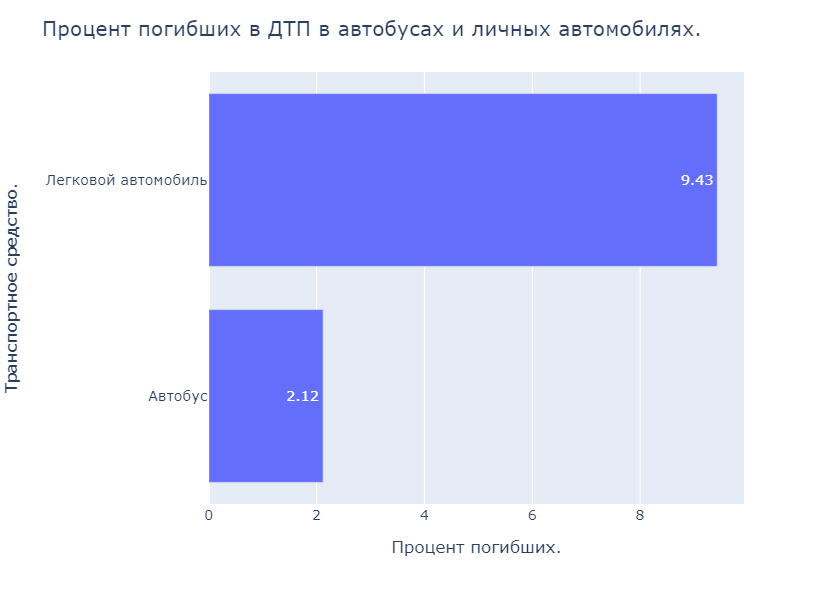

In [227]:
fig = px.bar(vehicles_d1.sort_values(by = "percent"),
             x = "percent",
             y = "class",
             text = "percent"
            )
fig.update_layout( title = "Процент погибших в ДТП в автобусах и личных автомобилях.",
                   xaxis_title = "Процент погибших.",
                   yaxis_title = "Транспортное средство.")
fig.show()

Как видно на графике, процент погибших в ДТП для личных автомобилей выше.

Посмотрим на статистику.

**Нулевая гипотеза:**<br>
Среди погибших в ДТП водителей и пассажиров автобусов не больше, чем водителей и пассажиров лекговых автомобилей.<br>
**Альтернативная гипотеза:**<br>
Среди погибших в ДТП водителей и пассажиров автобусов больше, чем водителей и пассажиров легковых автомобилей.

In [228]:
alpha = 0.05 # критический уровень статистической значимости

victims_d_b = np.array([buses_d, cars_d])
all_part_d_b = np.array([len(buses), len(cars)])

In [229]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print("p-значение: ", p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: Доля погибших в ДТП в автобусах больше, чем в личных автомобилях")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу: в доле погибших в ДТП в автобусах и личных автомобилях нет значимой разницы"
        )




In [230]:
z_test(victims_d_b, all_part_d_b, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу: Доля погибших в ДТП в автобусах больше, чем в личных автомобилях


Поскольку эти выборки большие и неравноценные t-test проводить не будем.

Посмотрим на распределение. Посчитаем среднее на произвольной выборке в 1000 значений. Расчёт произведём 100 раз.

In [231]:
mean_b = []

for i in range(100):
    mean_b.append(buses.sample(1000)["dead_count"].mean())

In [232]:
len(mean_b)

100

In [233]:
mean_с = []

for i in range(100):
    mean_с.append(cars.sample(1000)["dead_count"].mean())

In [234]:
len(mean_с)

100

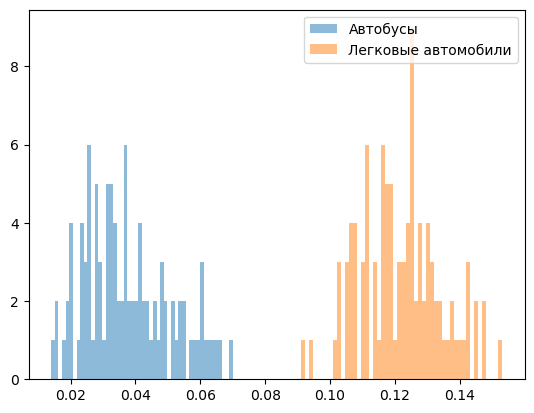

In [235]:
bins = 50

plt.hist(mean_b, bins, alpha = 0.5, label = "Автобусы")
plt.hist(mean_с, bins, alpha = 0.5, label = "Легковые автомобили")
plt.legend(loc = "upper right")

plt.show()

В среднем, количество погибших больше в легковых автомобилях, при этом наблюдается смещение влево в обеих выборках. 

**Количество пострадавших.**

In [236]:
vehicles_i = vehicles_all.groupby("class")["injured_count"].agg(["count", "max", "mean", "sum"]).reset_index()
vehicles_i

,class,count,max,mean,sum
0,Автобус,32963,44,1.483846,48912
1,Легковой автомобиль,780970,30,1.448076,1130904


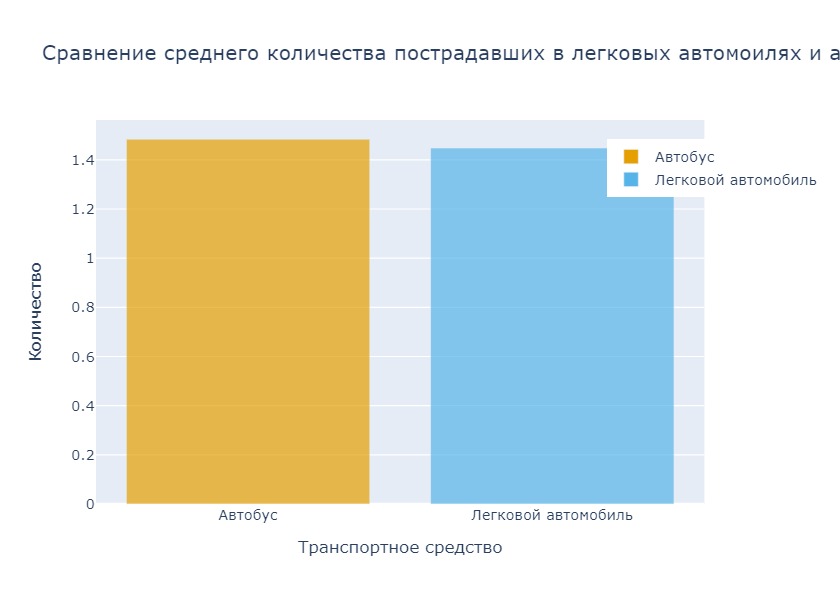

In [237]:
vehicles_i1 = vehicles_i[vehicles_i["class"] == "Автобус"]
vehicles_i2 = vehicles_i[vehicles_i["class"] == "Легковой автомобиль"]

fig = pg.Figure()
fig.add_trace(pg.Bar(x = vehicles_i1["class"], y = vehicles_i1["mean"],\
                     name = "Автобус", marker = {"color": "#E69F00", "opacity": 0.7}))
fig.add_trace(pg.Bar(x = vehicles_i2["class"], y = vehicles_i2["mean"],\
                     name = "Легковой автомобиль", marker = {"color": "#56B4E9", "opacity": 0.7}))
fig.update_layout(title = "Сравнение среднего количества пострадавших в легковых автомоилях и автобусах",\
                  xaxis_title = "Транспортное средство", yaxis_title = "Количество", legend = dict(y = 0.95, x = 0.84))
fig.update_traces(hoverinfo = "all", hovertemplate = "Количество: %{y}")

fig.show()

Как видно на этом графике, среднее количество пострадавших немного выше в автобусе, что логично, так как в автобусах больше людей ездит.

Посчитаем корреляцию.

In [238]:
vehicles_s1 = vehicles_all

In [239]:
vehicles_s1["classification"] = vehicles_s1["class"].apply(classification)

In [240]:
vehicles_s1 = vehicles_s1[["id", "classification", "injured_count"]]

In [241]:
vehicles_s1.head()

,id,classification,injured_count
0,1527480,0,1
1,1527481,1,1
2,1527483,0,1
4,1527485,0,2
5,1527487,0,1


In [242]:
vehicles_s1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813933 entries, 0 to 960273
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813933 non-null  int32 
 1   classification  813933 non-null  object
 2   injured_count   813933 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 21.7+ MB


In [243]:
vehicles_s1["classification"] = vehicles_s1["classification"].astype("int32")
vehicles_s1["injured_count"] = vehicles_s1["injured_count"].astype("int32")

In [244]:
vehicles_s1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813933 entries, 0 to 960273
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id              813933 non-null  int32
 1   classification  813933 non-null  int32
 2   injured_count   813933 non-null  int32
dtypes: int32(3)
memory usage: 15.5 MB


In [245]:
vehicles_s1["classification"].corr(vehicles_s1["injured_count"])

0.0070666128035011015

In [246]:
vehicles_s1[["classification", "injured_count"]].corr(method = "spearman")

,classification,injured_count
classification,1.000000,-0.046337
injured_count,-0.046337,1.000000


In [247]:
spearmanr(vehicles_s1[["classification", "injured_count"]])

SignificanceResult(statistic=-0.04633700866164553, pvalue=0.0)

В этом случае, корреляция также слабо выражена.

Разделим автобусы и легковые автомобили.

In [248]:
buses1_i = vehicles_s1[vehicles_s1["classification"] == 1]
cars1_i = vehicles_s1[vehicles_s1["classification"] == 0]

In [249]:
buses1_i.head()

,id,classification,injured_count
1,1527481,1,1
15,1527512,1,1
22,1527523,1,2
90,1527652,1,1
94,1527659,1,1


In [250]:
cars1_i.head()

,id,classification,injured_count
0,1527480,0,1
2,1527483,0,1
4,1527485,0,2
5,1527487,0,1
6,1527493,0,3


In [251]:
buses_i = len(buses1_i[buses1_i["injured_count"] != 0]["injured_count"])
buses_i1 = len(buses1_i[buses1_i["injured_count"] == 0]["injured_count"])
cars_i = len(cars1_i[cars1_i["injured_count"] != 0]["injured_count"])
cars_i1 = len(cars1_i[cars1_i["injured_count"] == 0]["injured_count"])

Посчитаем количество ДТП с пострадавшими.

In [252]:
print(f"Автобусы\n\
    Всего ДТП: - {len(buses1_i)}\n\
    ДТП с пострадавшими: - {buses_i}\n\
    ДТП без пострадавших:  - {buses_i1}\n\
    Процент ДТП с пострадавшими: {buses_i/len(buses1_i):.2%}")

Автобусы
    Всего ДТП: - 32963
    ДТП с пострадавшими: - 32719
    ДТП без пострадавших:  - 244
    Процент ДТП с пострадавшими: 99.26%


In [253]:
print(f"Легковые автомобили\n\
    Всего ДТП: - {len(cars1_i)}\n\
    ДТП с пострадавшими: - {cars_i}\n\
    ДТП без пострадавших:  - {cars_i1}\n\
    Процент ДТП с пострадавшими: {cars_i/len(cars1_i):.2%}")

Легковые автомобили
    Всего ДТП: - 780970
    ДТП с пострадавшими: - 750069
    ДТП без пострадавших:  - 30901
    Процент ДТП с пострадавшими: 96.04%


In [254]:
buses2 = buses1_i[buses1_i["injured_count"] != 0].groupby("classification")["injured_count"].agg(["count"]).reset_index()
cars2 = cars1_i[cars1_i["injured_count"] != 0].groupby("classification")["injured_count"].agg(["count"]).reset_index()

In [255]:
buses2["percent"] = round(buses_i/len(buses1_i) * 100, 2)
cars2["percent"] = round(cars_i/len(cars1_i) * 100, 2)

In [256]:
buses2

,classification,count,percent
0,1,32719,99.26


In [257]:
cars2

,classification,count,percent
0,0,750069,96.04


In [258]:
vehicles_i1 = vehicles_all[vehicles_all["injured_count"] != 0].groupby("class")["injured_count"].agg(["count"]).reset_index()
vehicles_i1

,class,count
0,Автобус,32719
1,Легковой автомобиль,750069


In [259]:
vehicles_p2 = pd.concat([buses2, cars2], ignore_index = True)

In [260]:
vehicles_i1["percent"] = vehicles_p2["percent"]

In [261]:
vehicles_i1

,class,count,percent
0,Автобус,32719,99.26
1,Легковой автомобиль,750069,96.04


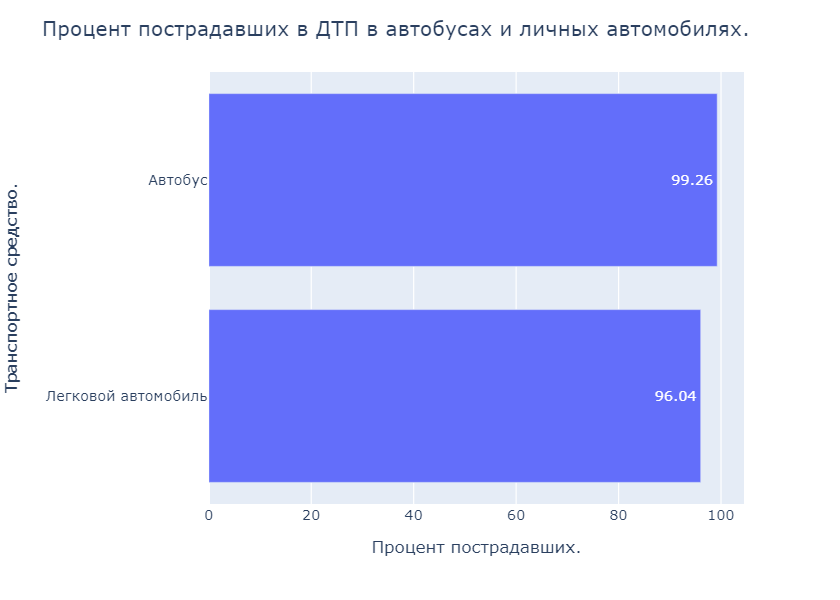

In [262]:
fig = px.bar(vehicles_i1.sort_values(by = "percent"),
             x = "percent",
             y = "class",
             text = "percent"
            )
fig.update_layout( title = "Процент пострадавших в ДТП в автобусах и личных автомобилях.",
                   xaxis_title = "Процент пострадавших.",
                   yaxis_title = "Транспортное средство.")
fig.show()

Процент пострадавших в ДТП также выше в автобусах.

Посмотрим на статистику.

**Нулевая гипотеза:**<br>
Среди пострадавших в ДТП водителей и пассажиров автобусов не больше, чем водителей и пассажиров лекговых автомобилей.<br>
**Альтернативная гипотеза:**<br>
Среди пострадавших в ДТП водителей и пассажиров автобусов больше, чем водителей и пассажиров легковых автомобилей.

In [263]:
alpha = 0.05 # критический уровень статистической значимости

victims_i = np.array([buses_i, cars_i])
all_part_i = np.array([len(buses1_i), len(cars1_i)])

In [264]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print("p-значение: ", p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: Доля пострадавших в ДТП в автобусах больше, чем в личных автомобилях")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу: в доле пострадавших в ДТП в автобусах и личных автомобилях нет значимой разницы"
        )




In [265]:
z_test(victims_i, all_part_i, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу: Доля пострадавших в ДТП в автобусах больше, чем в личных автомобилях


Как и в предыдущем случае, из-за величины и неоднородности выборок t-test проводить не будем.

Также посмотрим на распределение и посчитаем среднее на произвольной выборке. Её размер и количество подсчётов будет таким же как и в подсчёте количества погибших.

In [266]:
mean_i_b = []

for i in range(100):
    mean_i_b.append(buses1_i.sample(1000)["injured_count"].mean())

In [267]:
len(mean_i_b)

100

In [268]:
mean_i_с = []

for i in range(100):
    mean_i_с.append(cars1_i.sample(1000)["injured_count"].mean())

In [269]:
len(mean_i_с)

100

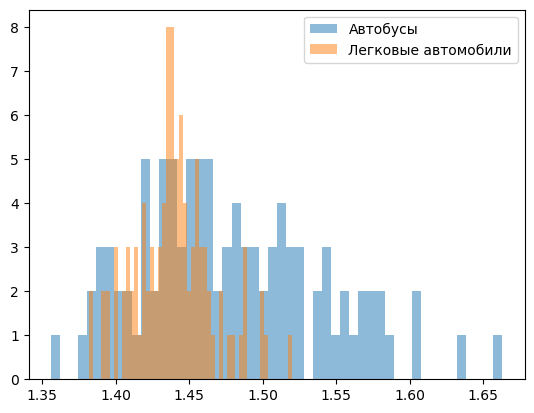

In [270]:
bins = 50

plt.hist(mean_i_b, bins, alpha = 0.5, label = "Автобусы")
plt.hist(mean_i_с, bins, alpha = 0.5, label = "Легковые автомобили")
plt.legend(loc = "upper right")

plt.show()

В среднем, пострадавших значительно больше в автобусах, при этом наблюдается некотоое смещение влево в выборке с автобусами.

**Итог по разделу:**<br>
1. Среднее количество погибших больше в автомобилях.
2. Макимальное возможное количество погибших больше в автобусах.
3. Среднее и максимально возможное количество пострадавших больше в автобусах.

**Вывод:**<br>
Несмотря на то, что в целом погибших больше в легковых автомобилях, макимальные значения этого показателя именно у автобусов. Обусловленно это тем, что автомобилей вообще больше и, соответственно, ДТП с их участием тоже в несколько раз больше. Поэтому, если смотреть на общие показатели, то они будут выше именно у легковых автомобилей. Однако, если смотреть на отдельные значения, то максимально возможное количество погибших в одной аварии приходится на категорию "Автобусы", что объяснется тем, что в них ездит гораздо больше людей.<br>
Этим же объясняется и более высокий, чем у легковых автомобилей, показатель пострадавших в ДТП. Пострадавшие, судя по полученным данным, есть практически в каждой аварии и если брать не суммарные показатели (которые выше у автомобилей за счёт их количества), а среднее значение, процент и статистические данные (учитывая, что автобусов и, соответственно, ДТП с их участием, меньше, но людей в них ездит больше) то у автобусов этот показатель значительно выше.<br>
Иными словами можно сказать, что в целом погибших больше в ДТП с участием легковых автомобилей, но макисмальное возможное количество погибших в одной аварии у автобусов и вообще пострадавших (как погибших, так и получивших травмы) больше именно в этой категории.<br>
**На основании изложенного, нельзя утверждать, что в автобусах ездить безопаснее, чем в автомобилях. Однако, и утверждать обратное, также нельзя из-за того, что, как показало исследование, корреляция между категорией транспорта и количеством пострадавших выражена слабо, что говорит о наличии других факторов.**

**Рекомендации:**<br>
Учитывая сложность вопроса и неоднозначность выводов, рекоменуется провести угублённое исследование данного вопроса (сейчас это выходит за рамки исследования) с использованием более широкого спектра данных.

**4. Если пешеходы не будут нарушать, то не будут гибнуть.**

Сделаем предположение, что пешеходы чаще всего гибнут в том случае, когда нарушают Правила дорожного движения.

In [271]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3499172 entries, 0 to 28534
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 173.5+ MB


In [272]:
pedestrians = participants[participants["role"] == "Пешеход"].reset_index(drop = True)

In [273]:
pedestrians.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2591468,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...,NaN
1,2731936,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на амбулат...",NaN
2,2711881,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",NaN
3,2746342,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,Скончался на месте ДТП по прибытию скорой меди...,NaN
4,2565579,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на стацион...",NaN


In [274]:
pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435479 entries, 0 to 435478
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           435479 non-null  int32  
 1   role                         435479 non-null  object 
 2   gender                       426847 non-null  object 
 3   violations                   435479 non-null  object 
 4   health_status                435460 non-null  object 
 5   years_of_driving_experience  0 non-null       float64
dtypes: float64(1), int32(1), object(4)
memory usage: 18.3+ MB


In [275]:
pedestrians["violations"].value_counts()

violations
[]                                                                                                                                                                                                                                                                                                          264891
[Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода]                                                                                                                                       51512
[Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)]                                                                                                                                                                                                            25331
[Иные нарушения]                                                    

In [276]:
def violations (row):
    row_list = row["violations"]
    if len(row_list) != 0:
        for violation in row_list:
            if "Переход" in violation and "проезж" in violation:
                return "Нарушение правил перехода."
            if "проезж" in violation:
                return "Нахождение на проезжей части."
            if "регул" in violation:
                return "Неподчинение сигналам регулирования."
            else:
                return "Иные нарушения."

In [277]:
pedestrians.isna().sum()

id                                  0
role                                0
gender                           8632
violations                          0
health_status                      19
years_of_driving_experience    435479
dtype: int64

In [278]:
pedestrians["type"] = pedestrians.apply(violations, axis = 1)

In [279]:
pedestrians.head()

,id,role,gender,violations,health_status,years_of_driving_experience,type
0,2591468,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...,NaN,None
1,2731936,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на амбулат...",NaN,Нахождение на проезжей части.
2,2711881,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",NaN,None
3,2746342,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,Скончался на месте ДТП по прибытию скорой меди...,NaN,Нахождение на проезжей части.
4,2565579,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на стацион...",NaN,Нахождение на проезжей части.


In [280]:
pedestrians["type"].value_counts()

type
Нарушение правил перехода.              81856
Иные нарушения.                         46883
Нахождение на проезжей части.           28347
Неподчинение сигналам регулирования.    13502
Name: count, dtype: int64

In [281]:
pedestrians.isna().sum()

id                                  0
role                                0
gender                           8632
violations                          0
health_status                      19
years_of_driving_experience    435479
type                           264891
dtype: int64

Пропуски в столбце с указанием типа нарушения связаны с отсутствующими значениями в столбце "violations", что может означать, что, в данном случае, виноват не пешеход.

In [282]:
pedestrians["type"] = pedestrians["type"].fillna("Не виновен")

In [283]:
pedestrians.isna().sum()

id                                  0
role                                0
gender                           8632
violations                          0
health_status                      19
years_of_driving_experience    435479
type                                0
dtype: int64

In [284]:
pedestrians["type"].value_counts()

type
Не виновен                              264891
Нарушение правил перехода.               81856
Иные нарушения.                          46883
Нахождение на проезжей части.            28347
Неподчинение сигналам регулирования.     13502
Name: count, dtype: int64

Text(0.5, 1.0, 'Вид нарушения')

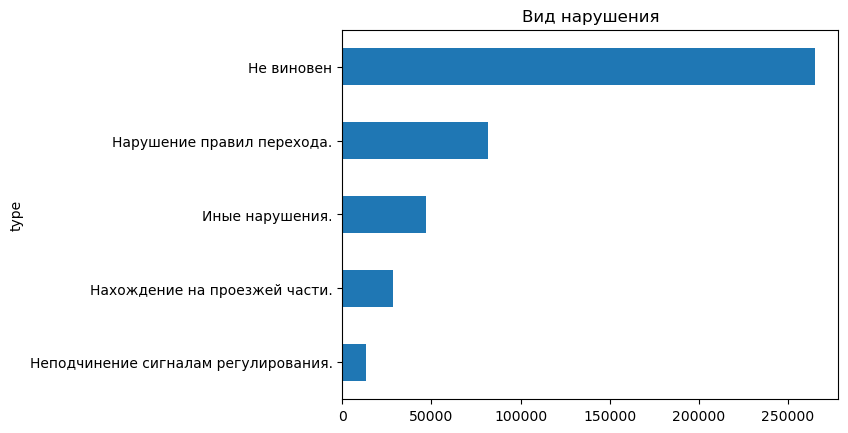

In [285]:
pedestrians["type"].value_counts(ascending = True).plot(kind = "barh")
plt.title("Вид нарушения")

Наиболее частым нарушением, является нарушение пешеходами правил перехода проезжей части, что также подтверждается практикой.

In [286]:
pedestrians["health_status"].value_counts()

health_status
Раненый, находящийся (находившийся) на стационарном лечении                                                                                                                                                   151951
Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)    142821
Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара                                                                                                               81208
Скончался на месте ДТП до приезда скорой медицинской помощи                                                                                                                                                    24524
Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)                     

In [287]:
pedestrians = pedestrians[pedestrians["health_status"] != "Не пострадал"]

Погибших обозначим "1", остальных "0".

In [288]:
def casualty (row):
    
    if "Скончался" in row:
        return "1"
    else:
        return "0"

In [289]:
pedestrians = pedestrians.dropna(subset = ["health_status"])

In [290]:
pedestrians["casualties"] = pedestrians["health_status"].apply(casualty)

Разделим виновных и невиновных.

In [291]:
def innocence (row):
    
    if "Не виновен" in row:
        return "Не виновен"
    else:
        return "Виновен"

In [292]:
pedestrians["innocence"] = pedestrians["type"].apply(innocence)

In [293]:
pedestrians.head()

,id,role,gender,violations,health_status,years_of_driving_experience,type,casualties,innocence
0,2591468,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...,NaN,Не виновен,0,Не виновен
1,2731936,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на амбулат...",NaN,Нахождение на проезжей части.,0,Виновен
2,2711881,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",NaN,Не виновен,0,Не виновен
3,2746342,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,Скончался на месте ДТП по прибытию скорой меди...,NaN,Нахождение на проезжей части.,1,Виновен
4,2565579,Пешеход,Мужской,[Передвижение по проезжей части на скейтборде ...,"Раненый, находящийся (находившийся) на стацион...",NaN,Нахождение на проезжей части.,0,Виновен


In [294]:
pedestrians = pedestrians[["id", "role", "type", "casualties", "innocence"]]

In [295]:
pedestrians.head()

,id,role,type,casualties,innocence
0,2591468,Пешеход,Не виновен,0,Не виновен
1,2731936,Пешеход,Нахождение на проезжей части.,0,Виновен
2,2711881,Пешеход,Не виновен,0,Не виновен
3,2746342,Пешеход,Нахождение на проезжей части.,1,Виновен
4,2565579,Пешеход,Нахождение на проезжей части.,0,Виновен


In [296]:
pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433645 entries, 0 to 435478
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          433645 non-null  int32 
 1   role        433645 non-null  object
 2   type        433645 non-null  object
 3   casualties  433645 non-null  object
 4   innocence   433645 non-null  object
dtypes: int32(1), object(4)
memory usage: 18.2+ MB


In [297]:
pedestrians.isna().sum()

id            0
role          0
type          0
casualties    0
innocence     0
dtype: int64

pedestrians = pedestrians.dropna()

In [298]:
pedestrians.duplicated().sum()

18324

In [299]:
pedestrians["id"].duplicated().sum()

20645

In [300]:
pedestrians.loc[pedestrians.duplicated()].head(30)

,id,role,type,casualties,innocence
18,2827838,Пешеход,Не виновен,0,Не виновен
57,2604597,Пешеход,Не виновен,0,Не виновен
121,2771100,Пешеход,Не виновен,0,Не виновен
125,2539275,Пешеход,Не виновен,0,Не виновен
126,2539275,Пешеход,Не виновен,0,Не виновен
155,2579700,Пешеход,Нахождение на проезжей части.,0,Виновен
178,2783102,Пешеход,Не виновен,0,Не виновен
184,2783097,Пешеход,Не виновен,0,Не виновен
191,2596744,Пешеход,Неподчинение сигналам регулирования.,0,Виновен
198,2880507,Пешеход,Не виновен,0,Не виновен


In [301]:
pedestrians.loc[pedestrians["id"].duplicated()].head(30)

,id,role,type,casualties,innocence
18,2827838,Пешеход,Не виновен,0,Не виновен
56,2604597,Пешеход,Не виновен,1,Не виновен
57,2604597,Пешеход,Не виновен,0,Не виновен
121,2771100,Пешеход,Не виновен,0,Не виновен
125,2539275,Пешеход,Не виновен,0,Не виновен
126,2539275,Пешеход,Не виновен,0,Не виновен
155,2579700,Пешеход,Нахождение на проезжей части.,0,Виновен
178,2783102,Пешеход,Не виновен,0,Не виновен
184,2783097,Пешеход,Не виновен,0,Не виновен
191,2596744,Пешеход,Неподчинение сигналам регулирования.,0,Виновен


In [302]:
pedestrians.loc[pedestrians["id"] == 2579700]

,id,role,type,casualties,innocence
154,2579700,Пешеход,Нахождение на проезжей части.,0,Виновен
155,2579700,Пешеход,Нахождение на проезжей части.,0,Виновен


In [303]:
data.loc[data["id"] == 2579700]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
293,"[83.741215, 53.352274]",2579700,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.352274,83.741215,"[Жилые дома индивидуальной застройки, Нерегули...",Барнаул,830,"г Барнаул, ул Спортивная, 76",[Ясно],Наезд на пешехода,2021-06-02 20:30:00,Легкий,0,2,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Пешеходы, Мотоциклисты, Дети]"


In [304]:
participants.loc[participants["id"] == 2579700]

,id,role,gender,violations,health_status,years_of_driving_experience
561,2579700,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на упра...",Не пострадал,NaN
52372,2579700,Пешеход,Женский,[Игра на проезжей части],Получил телесные повреждения с показанием к ле...,NaN
52373,2579700,Пешеход,Женский,[Игра на проезжей части],Получил телесные повреждения с показанием к ле...,NaN


In [305]:
pedestrians.loc[pedestrians["id"] == 2801366]

,id,role,type,casualties,innocence
4888,2801366,Пешеход,Нахождение на проезжей части.,1,Виновен
4889,2801366,Пешеход,Нахождение на проезжей части.,1,Виновен


In [306]:
data.loc[data["id"] == 2801366]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
10725,"[79.220417, 53.317518]",2801366,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",53.317518,79.220417,"[Жилые дома индивидуальной застройки, АЗС, Ино...",Немецкий национальный район,830,Крутиха - Панкрушиха - Хабары - Славгород - гр...,[Ясно],Наезд на пешехода,2022-12-16 19:40:00,С погибшими,2,0,Алтайский край,"[Обработанное противогололедными материалами, ...",3,"[Все участники, Пешеходы]"


In [307]:
participants.loc[participants["id"] == 2801366]

,id,role,gender,violations,health_status,years_of_driving_experience
20687,2801366,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,Не пострадал,15.0
57164,2801366,Пешеход,Мужской,[Нахождение на проезжей части без цели её пере...,Скончался на месте ДТП до приезда скорой медиц...,NaN
57165,2801366,Пешеход,Мужской,[Нахождение на проезжей части без цели её пере...,Скончался на месте ДТП до приезда скорой медиц...,NaN


In [308]:
pedestrians.loc[pedestrians["id"] == 2604597]

,id,role,type,casualties,innocence
55,2604597,Пешеход,Не виновен,0,Не виновен
56,2604597,Пешеход,Не виновен,1,Не виновен
57,2604597,Пешеход,Не виновен,0,Не виновен


In [309]:
data.loc[data["id"] == 2604597]

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
115,"[83.734435, 53.381069]",2604597,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",53.381069,83.734435,"[Многоквартирные жилые дома, Административные ...",Барнаул,830,None,[Ясно],Наезд на пешехода,2021-08-02 04:45:00,С погибшими,1,2,Алтайский край,[Сухое],4,"[Все участники, Пешеходы]"


In [310]:
participants.loc[participants["id"] == 2604597]

,id,role,gender,violations,health_status,years_of_driving_experience
228,2604597,Водитель,Женский,[Управление ТС в состоянии алкогольного опьяне...,Не пострадал,NaN
52272,2604597,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат...",NaN
52273,2604597,Пешеход,Мужской,[],Скончался на месте ДТП до приезда скорой медиц...,NaN
52274,2604597,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат...",NaN


Дубликаты составляют 4,8% от общего числа строк. Их можно удалить, чтобы избежать искажения результатов.

In [311]:
pedestrians = pedestrians.drop_duplicates()

In [312]:
pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415321 entries, 0 to 435478
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          415321 non-null  int32 
 1   role        415321 non-null  object
 2   type        415321 non-null  object
 3   casualties  415321 non-null  object
 4   innocence   415321 non-null  object
dtypes: int32(1), object(4)
memory usage: 17.4+ MB


In [313]:
pedestrians.isna().sum()

id            0
role          0
type          0
casualties    0
innocence     0
dtype: int64

In [314]:
pedestrians.duplicated().sum()

0

In [315]:
pedestrians["id"].duplicated().sum()

2321

In [316]:
pedestrians.loc[pedestrians["id"] == 2604597]

,id,role,type,casualties,innocence
55,2604597,Пешеход,Не виновен,0,Не виновен
56,2604597,Пешеход,Не виновен,1,Не виновен


In [317]:
pedestrians.duplicated(["id", "innocence"]).sum()

1776

In [318]:
pedestrians.loc[pedestrians[["id", "innocence"]].duplicated()].head(30)

,id,role,type,casualties,innocence
56,2604597,Пешеход,Не виновен,1,Не виновен
558,2947761,Пешеход,Не виновен,0,Не виновен
639,2746213,Пешеход,Не виновен,0,Не виновен
1025,2919692,Пешеход,Не виновен,1,Не виновен
1052,2907731,Пешеход,Не виновен,1,Не виновен
1908,2311314,Пешеход,Не виновен,1,Не виновен
1973,2311674,Пешеход,Нарушение правил перехода.,0,Виновен
1975,2311681,Пешеход,Не виновен,1,Не виновен
2113,2576796,Пешеход,Не виновен,1,Не виновен
3097,2319784,Пешеход,Не виновен,0,Не виновен


In [319]:
pedestrians.loc[pedestrians["id"] == 2947761]

,id,role,type,casualties,innocence
557,2947761,Пешеход,Не виновен,1,Не виновен
558,2947761,Пешеход,Не виновен,0,Не виновен


In [320]:
pedestrians.loc[pedestrians["id"] == 2758589]

,id,role,type,casualties,innocence
6732,2758589,Пешеход,Не виновен,0,Не виновен
6733,2758589,Пешеход,Не виновен,1,Не виновен


In [321]:
pedestrians.loc[pedestrians["id"] == 2746328]

,id,role,type,casualties,innocence
6196,2746328,Пешеход,Нахождение на проезжей части.,1,Виновен
6197,2746328,Пешеход,Нахождение на проезжей части.,0,Виновен


Скорее всего, в данном случае, эти дубликаты означают, что пешеходов было несколько. Общее их количество составляет 0,4%. Но, поскольку эти данные нужны для дальнейших расчётов, то оставим их без изменений.

In [322]:
pedestrians.head()

,id,role,type,casualties,innocence
0,2591468,Пешеход,Не виновен,0,Не виновен
1,2731936,Пешеход,Нахождение на проезжей части.,0,Виновен
2,2711881,Пешеход,Не виновен,0,Не виновен
3,2746342,Пешеход,Нахождение на проезжей части.,1,Виновен
4,2565579,Пешеход,Нахождение на проезжей части.,0,Виновен


In [323]:
pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415321 entries, 0 to 435478
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          415321 non-null  int32 
 1   role        415321 non-null  object
 2   type        415321 non-null  object
 3   casualties  415321 non-null  object
 4   innocence   415321 non-null  object
dtypes: int32(1), object(4)
memory usage: 17.4+ MB


In [324]:
pedestrians["casualties"] = pedestrians["casualties"].astype("int32")

In [325]:
pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415321 entries, 0 to 435478
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          415321 non-null  int32 
 1   role        415321 non-null  object
 2   type        415321 non-null  object
 3   casualties  415321 non-null  int32 
 4   innocence   415321 non-null  object
dtypes: int32(2), object(3)
memory usage: 15.8+ MB


In [326]:
pedestrians = pedestrians.pivot_table(index = "innocence", values = "casualties", aggfunc = "sum").reset_index()
pedestrians

,innocence,casualties
0,Виновен,30449
1,Не виновен,12950


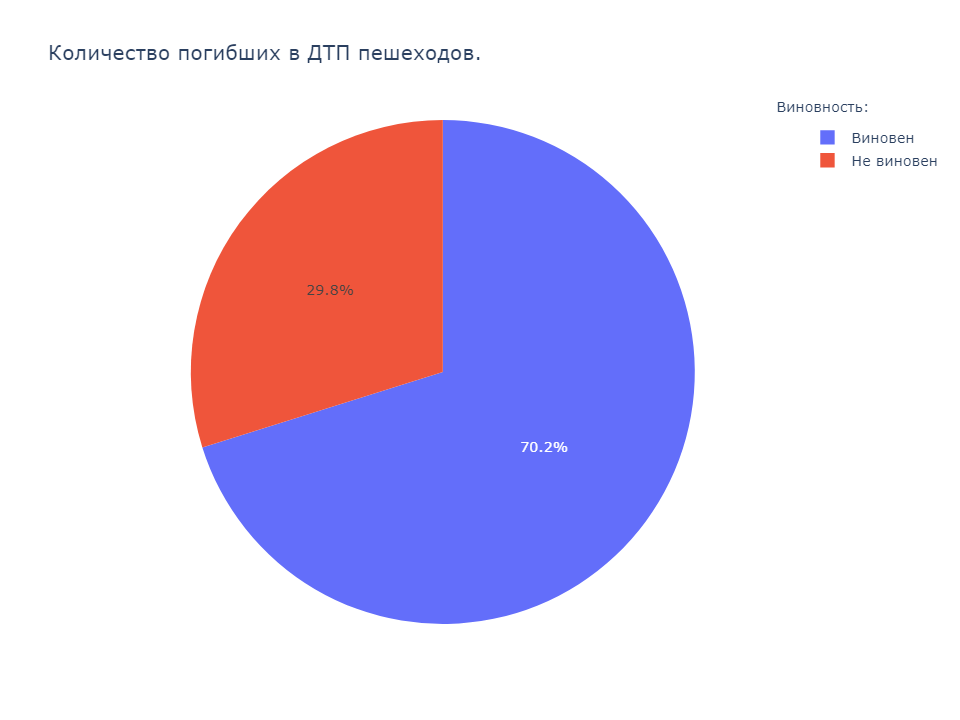

In [327]:
fig = pg.Figure(data = [pg.Pie(labels = pedestrians["innocence"],
                             values = pedestrians["casualties"])])
fig.update_layout(title = "Количество погибших в ДТП пешеходов.",
                  width = 800,
                  height = 600,
                  annotations = [dict(x = 1.12,
                                    y = 1.05,
                                    text = "Виновность:",
                                    showarrow = False)])

fig.show()

**Вывод:**<br>
Для исследования данного вопроса были отобраны пешеходы, которые были виновны в каком-либо нарушении Правил дорожного движения. Чаще всего, это был переход проезжей части в непредназначенном для этого месте. Сюда же можно отнести и "Неподчинение сигналам регулирования". Скорее всего, это означает переход дороги на красный свет. Здесь не учитывалась вина водителей, так как рассматривались только те случаи, когда был виновен пешеход, поэтому среди отобранных данных есть случаи когда виноваты были и те, и другие (например, пешеход находился на проезжей части, а водитель в свою очередь превысил скорость). Считаем это допустимым, так как вина пешехода здесь также есть. Например, можно утверждать, что если бы пешеход не находился на проезжей части, то, несмотря на превышение скорости водителем, он бы не пострадал. Среди пешеходов было посчитано количество погибших среди обеих категорий (виновные и невиновные).<br>
**По полученным данным видно, что доля погибших среди нарушивших пешеходов значительно выше, что вполне логично и подтверждается практикой.**

**6. Низкая скорость не влияет на тяжесть ДТП.**

Учитывая, что данных о скорости транспортных средств нет в представленных данных, рассмотрим предположение, что при превышении скорости доля тяжёлых травм и количество погибших выше, чем в остальных случаях.

In [328]:
speed = participants[(participants["role"] == "Водитель") | (participants["role"] == "Пассажир")].reset_index(drop = True)

In [329]:
speed.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [330]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008327 entries, 0 to 3008326
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 126.2+ MB


In [331]:
data["category"].value_counts()

category
Столкновение                                                                                                             605606
Наезд на пешехода                                                                                                        407271
Опрокидывание                                                                                                             86603
Съезд с дороги                                                                                                            85004
Наезд на препятствие                                                                                                      84897
Наезд на велосипедиста                                                                                                    46779
Падение пассажира                                                                                                         45510
Наезд на стоящее ТС                                                                            

In [332]:
data["severity"].value_counts()

severity
Легкий         809383
Тяжёлый        474894
С погибшими    135702
Name: count, dtype: int64

In [333]:
speed = speed[speed["health_status"] != "Не пострадал"]

In [334]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541248 entries, 4 to 3008324
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id                           1541248 non-null  int32  
 1   role                         1541248 non-null  object 
 2   gender                       1507364 non-null  object 
 3   violations                   1541248 non-null  object 
 4   health_status                1534790 non-null  object 
 5   years_of_driving_experience  646245 non-null   float64
dtypes: float64(1), int32(1), object(4)
memory usage: 76.4+ MB


In [335]:
speed["violations"].explode().unique()

array([nan, 'Выезд на полосу встречного движения',
       'Движение во встречном направлении по дороге с односторонним движением',
       'Управление ТС в состоянии алкогольного опьянения',
       'Другие нарушения ПДД водителем', 'Оставление места ДТП',
       'Несоблюдение требований ОСАГО',
       'Эксплуатация незарегистрированного ТС',
       'Несоответствие скорости конкретным условиям движения',
       'Управление ТС лицом, не имеющим права на управление ТС',
       'Нарушение правил применения мотошлема',
       'Нарушение правил пользования общественным транспортом',
       'Нарушение правил применения ремней безопасности пассажиром',
       'Несоблюдение очередности проезда',
       'Нарушение требований сигналов светофора',
       'Нарушение правил расположения ТС на проезжей части',
       'Несоблюдение бокового интервала', 'Нарушение правил перестроения',
       'Управление транспортным средством при наличии неисправностей или условий, при которых эксплуатация транспортног

In [336]:
speed["violations"].explode().value_counts()

violations
Несоблюдение требований ОСАГО                                                                                                                                                 117898
Несоответствие скорости конкретным условиям движения                                                                                                                           89638
Другие нарушения ПДД водителем                                                                                                                                                 85201
Нарушение правил расположения ТС на проезжей части                                                                                                                             80744
Управление ТС в состоянии алкогольного опьянения                                                                                                                               77645
                                                                                    

Здесь есть два нарушения, связанные со скоростью транспортного средства, это: "Несоответствие скорости конкретным условиям движения" и "Превышение установленной скорости движения". Под "несоответсвием скорости", чаще всего подразумевается превышение скорости в условиях плохой видимости, при перевозке особых грузов и т.д.

Обозначим их "1", остальные "0".

In [337]:
def over_speed(row):
    row_list = row["violations"]
    if len(row_list) != 0:
        for violation in row_list:
            if "скор" in violation:
                return 1
    return 0

In [338]:
speed["excess"] = speed.apply(over_speed, axis = 1)

In [339]:
speed.head()

,id,role,gender,violations,health_status,years_of_driving_experience,excess
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN,0
6,2576909,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на стацион...",NaN,0
8,2575209,Водитель,Мужской,[],"Раненый, находящийся (находившийся) на амбулат...",27.0,0
10,2547743,Водитель,Мужской,[Выезд на полосу встречного движения],"Раненый, находящийся (находившийся) на стацион...",10.0,0
11,2547743,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",NaN,0


In [340]:
speed["excess"].value_counts()

excess
0    1430004
1     111244
Name: count, dtype: int64

In [341]:
speed[speed["excess"] == 1]

,id,role,gender,violations,health_status,years_of_driving_experience,excess
30,2758611,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на стацион...",NaN,1
160,2831651,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на стацион...",33.0,1
199,2539353,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбулат...",21.0,1
214,2604800,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбулат...",47.0,1
308,2653482,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,Получил телесные повреждения с показанием к ле...,9.0,1
...,...,...,...,...,...,...,...
3007557,2383084,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на стацион...",NaN,1
3007884,2381198,Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбула...",NaN,1
3008007,2378600,Водитель,None,[Несоответствие скорости конкретным условиям д...,None,NaN,1
3008022,2378614,Водитель,Женский,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбула...",NaN,1


In [342]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541248 entries, 4 to 3008324
Data columns (total 7 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id                           1541248 non-null  int32  
 1   role                         1541248 non-null  object 
 2   gender                       1507364 non-null  object 
 3   violations                   1541248 non-null  object 
 4   health_status                1534790 non-null  object 
 5   years_of_driving_experience  646245 non-null   float64
 6   excess                       1541248 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 88.2+ MB


In [343]:
speed = speed.explode("violations").dropna().reset_index(drop = True)

In [344]:
speed.head()

,id,role,gender,violations,health_status,years_of_driving_experience,excess
0,2547743,Водитель,Мужской,Выезд на полосу встречного движения,"Раненый, находящийся (находившийся) на стацион...",10.0,0
1,2894043,Водитель,Мужской,Эксплуатация незарегистрированного ТС,Получил телесные повреждения с показанием к ле...,17.0,0
2,2315683,Водитель,Женский,Несоблюдение требований ОСАГО,"Раненый, находящийся (находившийся) на амбула...",7.0,0
3,2565493,Водитель,Мужской,Несоблюдение требований ОСАГО,"Раненый, находящийся (находившийся) на стацион...",7.0,0
4,2556392,Водитель,Женский,Несоблюдение очередности проезда,"Раненый, находящийся (находившийся) на амбулат...",5.0,0


In [345]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635930 entries, 0 to 635929
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           635930 non-null  int32  
 1   role                         635930 non-null  object 
 2   gender                       635930 non-null  object 
 3   violations                   635930 non-null  object 
 4   health_status                635930 non-null  object 
 5   years_of_driving_experience  635930 non-null  float64
 6   excess                       635930 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 31.5+ MB


In [346]:
speed = speed[["id", "excess"]]

In [347]:
speed.duplicated().sum()

237076

In [348]:
speed.head()

,id,excess
0,2547743,0
1,2894043,0
2,2315683,0
3,2565493,0
4,2556392,0


In [349]:
speed = speed.drop_duplicates().reset_index(drop = True)

In [350]:
speed["excess"].value_counts()

excess
0    313442
1     85412
Name: count, dtype: int64

In [351]:
data_s = data[(data["severity"] == "Тяжёлый") | (data["severity"] == "С погибшими")]

In [352]:
data_s = data_s[["id", "dead_count", "injured_count"]]

In [353]:
data_s.head()

,id,dead_count,injured_count
3,2576909,0,1
5,2547743,0,3
8,2771096,0,1
16,2758611,0,1
17,2758612,0,1


In [354]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610596 entries, 3 to 1419976
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   id             610596 non-null  int32
 1   dead_count     610596 non-null  int64
 2   injured_count  610596 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 16.3 MB


In [355]:
speed = speed.merge(data_s, on = "id", how = "left")

In [356]:
speed.head()

,id,excess,dead_count,injured_count
0,2547743,0,0.0,3.0
1,2894043,0,NaN,NaN
2,2315683,0,0.0,4.0
3,2565493,0,0.0,1.0
4,2556392,0,NaN,NaN


In [357]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398854 entries, 0 to 398853
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             398854 non-null  int32  
 1   excess         398854 non-null  int64  
 2   dead_count     212525 non-null  float64
 3   injured_count  212525 non-null  float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 10.7 MB


In [358]:
speed.isna().sum()

id                    0
excess                0
dead_count       186329
injured_count    186329
dtype: int64

In [359]:
speed = speed.dropna()

In [360]:
speed["dead_count"] = speed["dead_count"].astype("int32")
speed["injured_count"] = speed["injured_count"].astype("int32")

In [361]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212525 entries, 0 to 398853
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   id             212525 non-null  int32
 1   excess         212525 non-null  int64
 2   dead_count     212525 non-null  int32
 3   injured_count  212525 non-null  int32
dtypes: int32(3), int64(1)
memory usage: 5.7 MB


In [362]:
speed.describe().round(1)

,id,excess,dead_count,injured_count
count,212525.0,212525.0,212525.0,212525.0
mean,2230103.4,0.2,0.4,1.7
std,408847.5,0.4,0.7,1.5
min,1527508.0,0.0,0.0,0.0
25%,1853086.0,0.0,0.0,1.0
50%,2215595.0,0.0,0.0,1.0
75%,2581588.0,0.0,1.0,2.0
max,2957733.0,1.0,20.0,57.0


Максимальное количество погибших в ДТП, связанных с нарушением скоростного режима составляет 20 человек, пострадавших - 57.

In [363]:
speed.groupby("excess")["dead_count"].agg(["count", "max", "mean", "sum"])

,count,max,mean,sum
excess,,,,
0,163621,20,0.379731,62132
1,48904,19,0.369213,18056


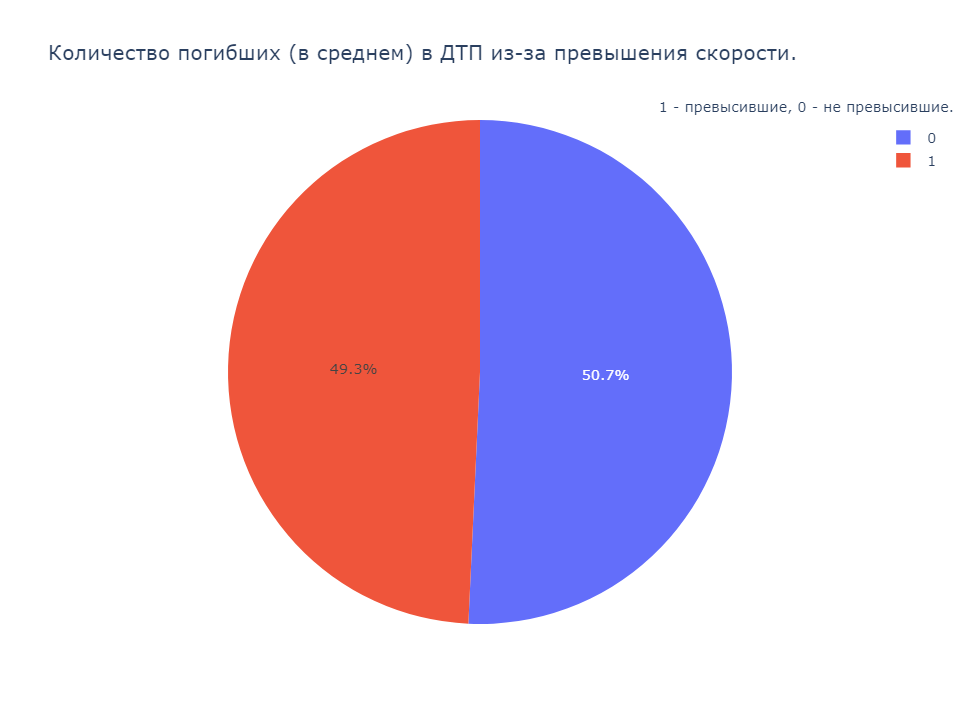

In [364]:
speed_g = speed.groupby("excess")["dead_count"].agg(["mean"]).round(3).reset_index()

fig = pg.Figure(data = [pg.Pie(labels = speed_g["excess"],
                               values = speed_g["mean"])]) 
fig.update_layout(title = "Количество погибших (в среднем) в ДТП из-за превышения скорости.",
                  width = 800,
                  height = 600,
                  annotations = [dict(x = 1.12,
                                    y = 1.05,
                                    text = "1 - превысившие, 0 - не превысившие.",
                                    showarrow = False)])

fig.show()

In [365]:
speed.groupby("excess")["injured_count"].agg(["count", "max", "mean", "sum"])

,count,max,mean,sum
excess,,,,
0,163621,44,1.743285,285238
1,48904,57,1.468735,71827


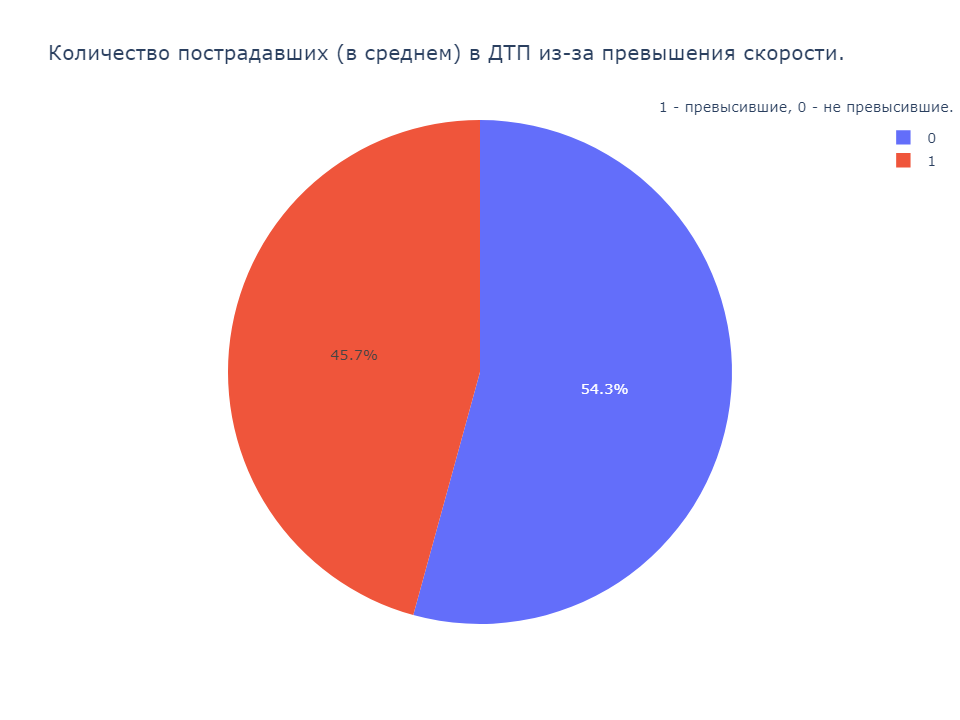

In [366]:
speed_g_i = speed.groupby("excess")["injured_count"].agg(["mean"]).round(3).reset_index()

fig = pg.Figure(data = [pg.Pie(labels = speed_g_i["excess"],
                               values = speed_g_i["mean"])]) 
fig.update_layout(title = "Количество пострадавших (в среднем) в ДТП из-за превышения скорости.",
                  width = 800,
                  height = 600,
                  annotations = [dict(x = 1.12,
                                    y = 1.05,
                                    text = "1 - превысившие, 0 - не превысившие.",
                                    showarrow = False)])

fig.show()

Среднее количество погибших и пострадавших больше среди тех, кто не превышал. Но таких водителей вообще больше.

In [367]:
speed["excess"].corr(speed["dead_count"])

-0.006243825736548687

In [368]:
speed[["excess", "dead_count"]].corr(method = "spearman")

,excess,dead_count
excess,1.000000,0.005203
dead_count,0.005203,1.000000


In [369]:
spearmanr(speed[["excess", "dead_count"]])

SignificanceResult(statistic=0.005202587798838307, pvalue=0.016466077682916237)

In [370]:
speed["excess"].corr(speed["injured_count"])

-0.07867765095975526

In [371]:
speed[["excess", "injured_count"]].corr(method = "spearman")

,excess,injured_count
excess,1.000000,-0.090936
injured_count,-0.090936,1.000000


In [372]:
spearmanr(speed[["excess", "injured_count"]])

SignificanceResult(statistic=-0.09093562909424889, pvalue=0.0)

Корреляция и в отношении погибших, и в отношении пострадавших выражена слабо.

Создадим таблицы с погибшими и пострадавшими среди превысивших скорость и непревысивших.

**Количество погибших.**

In [373]:
speed_high_d = speed[speed["excess"] == 1]
speed_low_d = speed[speed["excess"] == 0]

In [374]:
speed_high_d = speed_high_d[["id", "excess", "dead_count"]]
speed_low_d =  speed_low_d[["id", "excess", "dead_count"]]

In [375]:
speed_high_d.head()

,id,excess,dead_count
5,2831651,1,0
10,2604800,1,0
19,2653482,1,0
20,2653488,1,0
43,2783098,1,0


In [376]:
speed_low_d.head()

,id,excess,dead_count
0,2547743,0,0
2,2315683,0,0
3,2565493,0,0
6,2577125,0,0
9,2605048,0,0


In [377]:
dead_exceeded = len(speed_high_d[speed_high_d["dead_count"] != 0]["dead_count"])
alive_exceeded = len(speed_high_d[speed_high_d["dead_count"] == 0]["dead_count"])
dead_not_exceeded = len(speed_low_d[speed_low_d["dead_count"] != 0]["dead_count"])
alive_not_exceeded = len(speed_low_d[speed_low_d["dead_count"] == 0]["dead_count"])

Посмотрим долю ДТП с погибшими.

In [378]:
print(f"Превысившие\n\
    Всего ДТП: - {len(speed_high_d)}\n\
    ДТП с погибшими: - {dead_exceeded}\n\
    ДТП без погибших:  - {alive_exceeded}\n\
    Процент ДТП с погибшими: {dead_exceeded/len(speed_high_d):.2%}")

Превысившие
    Всего ДТП: - 48904
    ДТП с погибшими: - 14539
    ДТП без погибших:  - 34365
    Процент ДТП с погибшими: 29.73%


In [379]:
print(f"Непревысившие\n\
    Всего ДТП: - {len(speed_low_d)}\n\
    ДТП с погибшими: - {dead_not_exceeded}\n\
    ДТП без погибших:  - {alive_not_exceeded}\n\
    Процент ДТП с погибшими: {dead_not_exceeded/len(speed_low_d):.2%}")

Непревысившие
    Всего ДТП: - 163621
    ДТП с погибшими: - 47146
    ДТП без погибших:  - 116475
    Процент ДТП с погибшими: 28.81%


In [380]:
speed_high_d = speed[speed["excess"] == 1]
speed_low_d

,id,excess,dead_count
0,2547743,0,0
2,2315683,0,0
3,2565493,0,0
6,2577125,0,0
9,2605048,0,0
...,...,...,...
398842,2566063,0,0
398845,2382221,0,0
398847,2382142,0,0
398850,2381422,0,1


In [381]:
speed_high_d1 = speed_high_d[speed_high_d["dead_count"] != 0].groupby("excess")["dead_count"].agg(["count"]).reset_index()
speed_low_d1 = speed_low_d[speed_low_d["dead_count"] != 0].groupby("excess")["dead_count"].agg(["count"]).reset_index()

In [382]:
speed_high_d1["percent"] = round(dead_exceeded/len(speed_high_d) * 100, 2)
speed_low_d1["percent"] = round(dead_not_exceeded/len(speed_low_d) * 100, 2)

In [383]:
speed_high_d1

,excess,count,percent
0,1,14539,29.73


In [384]:
speed_low_d1

,excess,count,percent
0,0,47146,28.81


In [385]:
def type_excess(excess):
    
    if excess == 1:
        return "Превысил"
        
    if excess == 0:
        return "Не превысил"

In [386]:
speed_p_d = speed
speed_p_d["category"] = speed_p_d["excess"].apply(type_excess)

In [387]:
speed_p_d.head()

,id,excess,dead_count,injured_count,category
0,2547743,0,0,3,Не превысил
2,2315683,0,0,4,Не превысил
3,2565493,0,0,1,Не превысил
5,2831651,1,0,1,Превысил
6,2577125,0,0,1,Не превысил


In [388]:
speed_p_d1 = speed_p_d[speed_p_d["dead_count"] != 0].groupby("category")["dead_count"].agg(["count"]).reset_index()
speed_p_d1

,category,count
0,Не превысил,47146
1,Превысил,14539


In [389]:
speed_a_d = pd.concat([speed_high_d1, speed_low_d1], ignore_index = True)

In [390]:
speed_p_d1["percent"] = speed_a_d["percent"]
speed_p_d1

,category,count,percent
0,Не превысил,47146,29.73
1,Превысил,14539,28.81


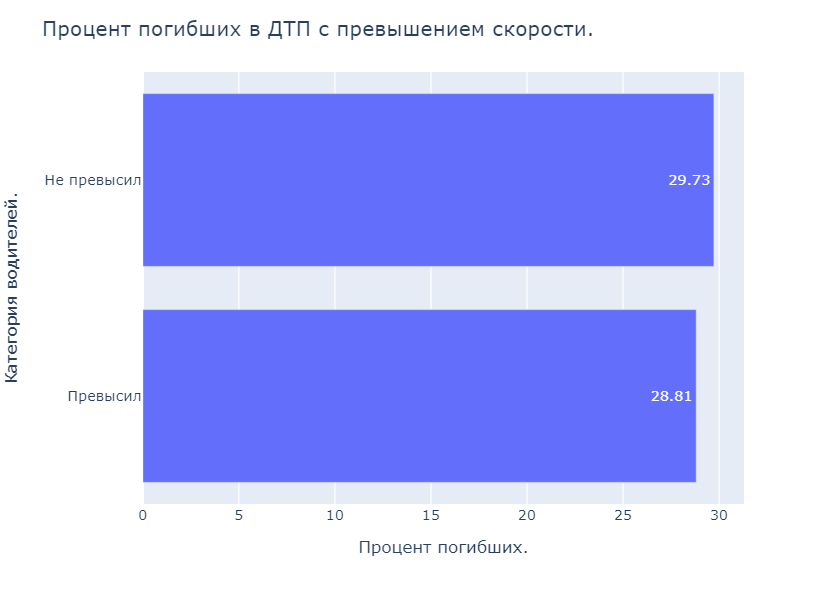

In [391]:
fig = px.bar(speed_p_d1.sort_values(by = "percent"),
             x = "percent",
             y = "category",
             text = "percent"
            )
fig.update_layout( title = "Процент погибших в ДТП с превышением скорости.",
                   xaxis_title = "Процент погибших.",
                   yaxis_title = "Категория водителей.")
fig.show()

Как видно из графика, процент погибших в ДТП среди тех, кто не превышал скорость, незначительно выше. Это необычно. Впрочем, разница невелика и составляет чуть менее 1%.

Посчитаем статистику.

**Нулевая гипотеза:**<br>
Среди погибших в ДТП водителей, преысивших скорость не больше, чем непревысивших.<br>
**Альтернативная гипотеза:**<br>
Среди погибших в ДТП водителей превысивших скорость больше, чем непревысивших.

In [392]:
alpha = 0.05 # критический уровень статистической значимости

victims_excess_d = np.array([dead_exceeded, dead_not_exceeded])
all_part_excess_d = np.array([len(speed_high_d),len(speed_low_d)])

In [393]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print("p-значение: ", p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: доля с погибшими в ДТП среди превысивших скорость больше, между группами есть разница")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу, доля с погибшими в ДТП среди превысивших скорость не больше, между группами нет разницы"
        )

In [394]:
z_test(victims_excess_d, all_part_excess_d, alpha)

p-значение:  4.539334519515492e-05
Отвергаем нулевую гипотезу: доля с погибшими в ДТП среди превысивших скорость больше, между группами есть разница


Проведём t-test.

In [395]:
p_value = st.ttest_ind(speed_low_d["dead_count"],
                       speed_high_d["dead_count"],
                       equal_var = False,
                       alternative = "greater")[1]

print("p-значение: ", p_value)
if p_value > alpha:
    print("Не удалось отвергнуть нулевую гипотезу")
else:
    print("Нулевая гипотеза отвергнута")

p-значение:  0.001305557858643307
Нулевая гипотеза отвергнута


**Количество пострадавших.**

In [396]:
speed_high_i = speed[speed["excess"] == 1]
speed_low_i = speed[speed["excess"] == 0]

In [397]:
speed_high_i = speed_high_i[["id", "excess", "injured_count"]]
speed_low_i =  speed_low_i[["id", "excess", "injured_count"]]

In [398]:
speed_high_i.head()

,id,excess,injured_count
5,2831651,1,1
10,2604800,1,4
19,2653482,1,2
20,2653488,1,1
43,2783098,1,1


In [399]:
speed_low_i.head()

,id,excess,injured_count
0,2547743,0,3
2,2315683,0,4
3,2565493,0,1
6,2577125,0,1
9,2605048,0,3


In [400]:
injured_exceeded = len(speed_high_i[speed_high_i["injured_count"] != 0]["injured_count"])
not_injured_exceeded = len(speed_high_i[speed_high_i["injured_count"] == 0]["injured_count"])
injured_not_exceeded = len(speed_low_i[speed_low_i["injured_count"] != 0]["injured_count"])
not_injured_not_exceeded = len(speed_low_i[speed_low_i["injured_count"] == 0]["injured_count"])

Посмотрим долю ДТП с пострадавшими.

In [401]:
print(f"Превысившие\n\
    Всего ДТП: - {len(speed_high_i)}\n\
    ДТП с пострадавшими: - {injured_exceeded}\n\
    ДТП без пострадавших:  - {not_injured_exceeded}\n\
    Процент ДТП с пострадавшими: {injured_exceeded/len(speed_high_i):.2%}")

Превысившие
    Всего ДТП: - 48904
    ДТП с пострадавшими: - 41639
    ДТП без пострадавших:  - 7265
    Процент ДТП с пострадавшими: 85.14%


In [402]:
print(f"Непревысившие\n\
    Всего ДТП: - {len(speed_low_i)}\n\
    ДТП с пострадавшими: - {injured_not_exceeded}\n\
    ДТП без пострадавших:  - {not_injured_not_exceeded}\n\
    Процент ДТП с пострадавшими: {injured_not_exceeded/len(speed_low_i):.2%}")

Непревысившие
    Всего ДТП: - 163621
    ДТП с пострадавшими: - 144611
    ДТП без пострадавших:  - 19010
    Процент ДТП с пострадавшими: 88.38%


In [403]:
speed_high_i = speed[speed["excess"] == 1]
speed_low_i

,id,excess,injured_count
0,2547743,0,3
2,2315683,0,4
3,2565493,0,1
6,2577125,0,1
9,2605048,0,3
...,...,...,...
398842,2566063,0,3
398845,2382221,0,1
398847,2382142,0,7
398850,2381422,0,1


In [404]:
speed_high_i1 = speed_high_i[speed_high_i["injured_count"] != 0].groupby("excess")["injured_count"].agg(["count"]).reset_index()
speed_low_i1 = speed_low_i[speed_low_i["injured_count"] != 0].groupby("excess")["injured_count"].agg(["count"]).reset_index()

In [405]:
speed_high_i1["percent"] = round(injured_exceeded/len(speed_high_i) * 100, 2)
speed_low_i1["percent"] = round(injured_not_exceeded/len(speed_low_i) * 100, 2)

In [406]:
speed_high_i1

,excess,count,percent
0,1,41639,85.14


In [407]:
speed_low_i1

,excess,count,percent
0,0,144611,88.38


In [408]:
speed_p_i = speed
speed_p_i["category"] = speed_p_i["excess"].apply(type_excess)

In [409]:
speed_p_i.head()

,id,excess,dead_count,injured_count,category
0,2547743,0,0,3,Не превысил
2,2315683,0,0,4,Не превысил
3,2565493,0,0,1,Не превысил
5,2831651,1,0,1,Превысил
6,2577125,0,0,1,Не превысил


In [410]:
speed_p_i1 = speed_p_i[speed_p_i["injured_count"] != 0].groupby("category")["injured_count"].agg(["count"]).reset_index()
speed_p_i1

,category,count
0,Не превысил,144611
1,Превысил,41639


In [411]:
speed_a_i = pd.concat([speed_high_i1, speed_low_i1], ignore_index = True)

In [412]:
speed_p_i1["percent"] = speed_a_i["percent"]
speed_p_i1

,category,count,percent
0,Не превысил,144611,85.14
1,Превысил,41639,88.38


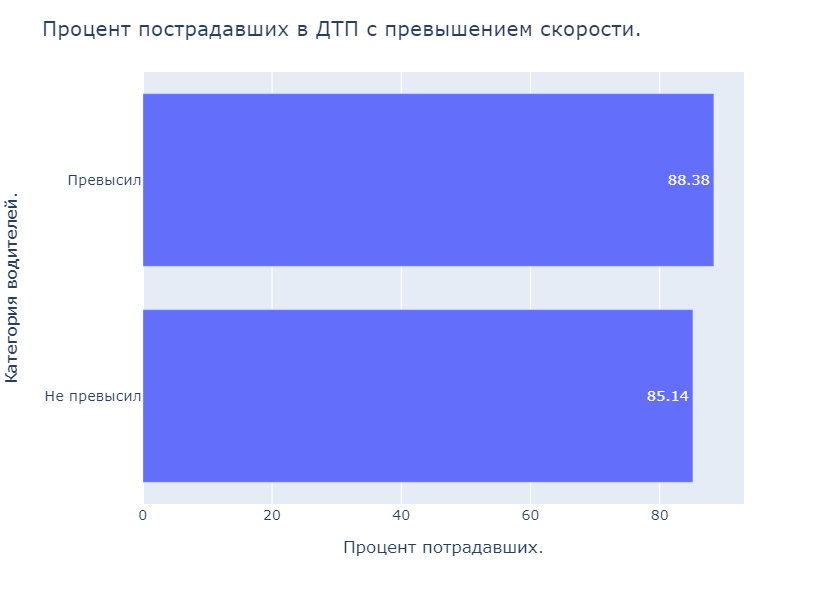

In [413]:
fig = px.bar(speed_p_i1.sort_values(by = "percent"),
             x = "percent",
             y = "category",
             text = "percent"
            )
fig.update_layout( title = "Процент пострадавших в ДТП с превышением скорости.",
                   xaxis_title = "Процент потрадавших.",
                   yaxis_title = "Категория водителей.")
fig.show()

В данном случае, процент пострадавших в ДТП выше среди тех, кто превышал скорость.

Посчитаем статистику.

**Нулевая гипотеза:**<br>
Среди пострадавших в ДТП водителей, преысивших скорость не больше, чем непревысивших.<br>
**Альтернативная гипотеза:**<br>
Среди пострадавших в ДТП водителей превысивших скорость больше, чем непрвеысивших.

In [414]:
alpha = 0.05 # критический уровень статистической значимости

victims_excess_i = np.array([injured_exceeded, injured_not_exceeded])
all_part_excess_i = np.array([len(speed_high_i),len(speed_low_i)])

In [415]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print("p-значение: ", p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: доля с пострадавшими в ДТП среди превысивших скорость больше, между группами есть разница")
    else:
        print(
            "Не получилось отвергнуть нулевую гипотезу, доля с пострадавшими в ДТП среди превысивших скорость не больше, между группами нет разницы"
        )

In [416]:
z_test(victims_excess_i, all_part_excess_i, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу: доля с пострадавшими в ДТП среди превысивших скорость больше, между группами есть разница


Проведём t-test.

In [417]:
p_value = st.ttest_ind(speed_low_i["injured_count"],
                       speed_high_i["injured_count"],
                       equal_var = False,
                       alternative = "greater")[1]

print("p-значение: ", p_value)
if p_value > alpha:
    print("Не удалось отвергнуть нулевую гипотезу")
else:
    print("Нулевая гипотеза отвергнута")

p-значение:  0.0
Нулевая гипотеза отвергнута


**Вывод:**<br>
Для анализа были отобраны ДТП, участники которых (водители и пассажиры) получили тяжёлые травмы или погибли. Они были также разделены на две категории: там, где водители превысили скорость и где не превысили. Как видно по результатам исследования, между группами есть разница, но она не настолько большая (от 1% до 3%), чтобы говорить о сильной взаимосвязи между этими двумя показателями. На количество погибших и пострадавших может также влиять и то какая дорога (грунтовая или нет, мокрая, обледенелая или нет), погодные условия, видимость и т.д. Все эти факторы, конечно также усугубляют превышение скорости. Однако, в данном исследовании все они были взяты в совокупности.<br>
**На основании изложенного можно утверждать, что превышение скорости существенным образом не влияет на тяжесть ДТП. Тем не менее, данный вопрос также требует дополнительного исследования, так как здесь наблюдается влияние множества сторонних факторов. Например, то, какая дорога (какое качество её, мокрая она, обледенелая или нет и т.д.), влияние алкогольного опьянения (как дополнительного фактора) т.д. Кроме этого, данное исследвание проводилось только в отношении водителей и пассажиров. И если смотреть только в отношении них, то тут статистика может и не различаться сильно. Однако, из-за превышения скорости (а также алкогольного опьянения водителей) часто страдают (и, может быть, даже в большей мере) и другие участники дорожного движения. Например, пешеходы. И если добавить статистику по ним, то результат может получиться иным. Например, известны случаи, когда превысивший скорость водитель (кроме этого, возможно и пьяный) не справившись с управление вылетел на остановку или тротуар, что сразу привело ко множеству пострадавших. При этом сам водитель мог и не пострадать.**

**Общий вывод:**<br>
1. ДТП с участием пьяных водителей приводит к гораздо более тяжёлым последствиям. Процент погибших в них значительно выше. Тем не менее установлено, что на этот показатель также могут иметь влияние и сторонние факторы. Кроме этого, стоит отметить, что процент таких ДТП на протяжении пяти лет имеет заметную тенденцию к снижению.
2. Безопасность на дорогах растёт для всех участников. Количество погибих и пострадавших постоянно плавно снижается.
3. В среднем, количество погибших больше в легковых автомобилях за счёт того, что ДТП с ними больше. А вот среднее количество пострадавших больше в автобусах так как в них вообще ездит больше людей, чем в автомобилях. Однако и ДТП с ними меньше. Также и максмальные значения по погибшим и раненным в одном ДТП больше у автобусов. Если брать средние значения и процентное соотношение, то в личном автомобиле ездить безопаснее, однако на показатели пострадавших также может влиять и большое количество сторонних факторов. Этот вопрос требует дальнейшего углублённого исследования.
4. Доля погибших среди нарушивших правила дорожного движения пешеходов значительно выше, что вполне логично и подтверждается практикой.
5. Превышение скорости существенным образом не влияет на тяжесть ДТП.

**Рекомендации:**
1. Несмотря на общую тенденцию к снижению пострадавших в ДТП с участием пьяных водителей, следует усилить работу по профилактике и предотвращению подобных нарушений.
2. Провести дополнительное, более углублённое исследование, вопроса более безопасной езды в личном автомобиле, чем в автобусе.
3. Учитывая, что имеет место много дополнительных факторов, вляющих на количество и тяжесть ДТП, провести исследование по ряду вопросов, не отражённых в ТЗ, а именно:
- влияние стажа водителя на аварийность.
- влияние пола водитея на аварийность.
- влияние страны производства автомобиля (отчественные или иномарки) на аварийность.
4. Изучить вопрос влияния погодных условий на аварийность.